## Bank of England Project Notebook

In [1]:
# Install the necessary libraries.
#!pip install nltk
#!pip install vaderSentiment
#!pip install textblob

In [2]:
# Import relevant libraries.
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
stop_words = set(stopwords.words('english'))

# Ignore

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lthom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lthom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\lthom\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lthom\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Data Exploration

In [3]:
# Load dataset. Change directory as required.
df = pd.read_csv('all_speeches.csv')

In [4]:
# View DataFrame
df.head(5)

,reference,country,date,title,author,is_gov,text
0,r901128a_BOA,australia,1990-11-28,A Proper Role for Monetary Policy,fraser,0,They would no doubt argue that to have two obj...
1,r911003a_BOA,australia,1991-10-03,,fraser,0,Today I wish to talk about real interest rates...
2,r920314a_BOA,australia,1992-03-14,,fraser,0,I welcome this opportunity to talk about prosp...
3,r920529a_BOA,australia,1992-05-29,,fraser,0,It is a pleasure to have this opportunity to a...
4,r920817a_BOA,australia,1992-08-17,,fraser,0,"As a long-time fan of Don Sanders, I am deligh..."


In [5]:
# View shape
df.shape

(7721, 7)

In [6]:
# Print info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7721 entries, 0 to 7720
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   reference  7721 non-null   object
 1   country    7721 non-null   object
 2   date       7721 non-null   object
 3   title      7721 non-null   object
 4   author     7721 non-null   object
 5   is_gov     7721 non-null   int64 
 6   text       7721 non-null   object
dtypes: int64(1), object(6)
memory usage: 422.4+ KB


In [7]:
# Look at speeches by country / area
df.country.value_counts()

country
euro area         2351
united states     1551
united kingdom    1209
japan              755
canada             620
sweden             600
switzerland        351
australia          284
Name: count, dtype: int64

In [8]:
# Check for duplicates
df.duplicated().sum()

0

In [9]:
# Check for duplicates in text column
df['text'].duplicated().sum()

29

**Observation:** 29 duplicates in the text column. 

In [10]:
# Determine the metadata of the data set.
df.dtypes

reference    object
country      object
date         object
title        object
author       object
is_gov        int64
text         object
dtype: object

In [11]:
# Create an empty DataFrame
df_date = pd.DataFrame(columns = ['year', 'month', 'day'])

# Split out the date to see how it's formatted.
df_date[['year', 'month', 'day']] = df['date'].str.split('-', expand=True)

In [12]:
# View max and min in month column. 
print(f"Min Month: {df_date['month'].min()}")
print(f"Max Month: {df_date['month'].max()}")

# Day
print(f"Min Day: {df_date['day'].min()}")
print(f"Max Day: {df_date['day'].max()}")

# Year
print(f"Min Year: {df_date['year'].min()}")
print(f"Max Year: {df_date['year'].max()}")

Min Month: 01
Max Month: 12
Min Day: 01
Max Day: 31
Min Year: 1900
Max Year: 2022


**Observation:** The date column is formatted YYYY-MM-DD - This is consistent across the entire dataset

In [13]:
# Convert date to date time format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Check
df.dtypes

reference            object
country              object
date         datetime64[ns]
title                object
author               object
is_gov                int64
text                 object
dtype: object

In [14]:
# Adding a column to calculate the string length per speech.
df['len'] = df['text'].str.len()

In [15]:
# Adding a month column that takes the month of each speech
df['year_month'] = df['date'].apply(lambda x: x.strftime('%Y-%m')) 
df['year'] = df['date'].apply(lambda x: x.strftime('%Y'))

# Return the weekday of the date (e.g., 'Monday', 'Tuesday', etc.)
df['weekday'] = df['date'].dt.day_name()

df['quarter'] = pd.PeriodIndex(df.date, freq='Q')

# Sort
df = df[['reference', 'country', 'date', 'quarter', 'year_month', 'weekday', 'year', 'title', 'author', 'is_gov', 'text', 'len']]

### UK Subset

In [16]:
# View UK subset
df[df['country']=='united kingdom'].sort_values('date').head(10)

,reference,country,date,quarter,year_month,weekday,year,title,author,is_gov,text,len
4961,r980915a_BOE,united kingdom,1998-09-15,1998Q3,1998-09,Tuesday,1998,Speech,george,0,"Thank you, Chairman. I'm actually very pleased...",13731
4962,r981021b_BOE,united kingdom,1998-10-21,1998Q4,1998-10,Wednesday,1998,Britain in Europe,george,0,It's a great pleasure to be here in the beauti...,24263
4963,r981021a_BOE,united kingdom,1998-10-21,1998Q4,1998-10,Wednesday,1998,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,13678
4964,r981101a_BOE,united kingdom,1998-11-01,1998Q4,1998-11,Sunday,1998,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,27679
4965,r981101b_BOE,united kingdom,1998-11-01,1998Q4,1998-11,Sunday,1998,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",27693
4966,r981119a_BOE,united kingdom,1998-11-19,1998Q4,1998-11,Thursday,1998,Speech,george,0,Let me put some of the recent newspaper headli...,13298
4967,r981201a_BOE,united kingdom,1998-12-01,1998Q4,1998-12,Tuesday,1998,Speech,governor,0,It is both an honour and a challenge to delive...,36920
4968,r981215a_BOE,united kingdom,1998-12-15,1998Q4,1998-12,Tuesday,1998,Alice in Euroland,buiter,0,Economic and Monetary Union has arrived de fac...,28791
4969,r990112a_BOE,united kingdom,1999-01-12,1999Q1,1999-01,Tuesday,1999,Speech,george,0,I am only too well aware of the pressure curre...,14819
4970,r990118a_BOE,united kingdom,1999-01-18,1999Q1,1999-01,Monday,1999,Speech,george,0,It would be a masterly understatement to descr...,14448


In [17]:
# Creating a new DataFrame with only UK speeches.
df_uk = df[df['country']=='united kingdom']

In [18]:
# View
df_uk.tail(15)

,reference,country,date,quarter,year_month,weekday,year,title,author,is_gov,text,len
6155,r220718a_BOE,united kingdom,2022-07-18,2022Q3,2022-07,Monday,2022,"Some reflections on Monetary Policy past, pres...",saunders,0,My January presentation at the Central Exchang...,16674
6156,r220719a_BOE,united kingdom,2022-07-19,2022Q3,2022-07,Tuesday,2022,"Bringing inflation back to the 2% target, no i...",bailey,1,"Lord Mayor, it is a great pleasure to be here ...",12120
6157,r220720a_BOE,united kingdom,2022-07-20,2022Q3,2022-07,Wednesday,2022,New tides,benjamin,0,International banks active in the UK: 2022 pri...,9738
6158,r220907a_BOE,united kingdom,2022-09-07,2022Q3,2022-09,Wednesday,2022,Household indebtedness and financial stability,bowe,0,Colette Bowe provides an overview of the Finan...,14235
6159,r220920a_BOE,united kingdom,2022-09-20,2022Q3,2022-09,Tuesday,2022,Who’s concentrating? Trends in the life insur...,gerken,0,Use of internal credit assessments for assigni...,78545
6160,r220927a_BOE,united kingdom,2022-09-27,2022Q3,2022-09,Tuesday,2022,The PRA's future approach to policy,saporta,0,"By responding to this consultation, you provid...",54957
6161,r220928a_BOE,united kingdom,2022-09-28,2022Q3,2022-09,Wednesday,2022,Innovation in post trade services,cunliffe,0,"In recent years, regulators and central banks ...",24800
6162,r220929a_BOE,united kingdom,2022-09-29,2022Q3,2022-09,Thursday,2022,Recent developments in the economy and markets,pill,0,Good evening everyone. It is a great pleasure ...,12835
6163,r220929b_BOE,united kingdom,2022-09-29,2022Q3,2022-09,Thursday,2022,Message received and understood,ramsden,0,These are the minutes of the special Monetary ...,44853
6164,r221006a_BOE,united kingdom,2022-10-06,2022Q4,2022-10,Thursday,2022,Current monetary policy,haskel,0,The current institutional arrangements for mon...,39622


In [19]:
# View shape
print(df_uk.shape)

# Reset index
df_uk = df_uk.reset_index(drop=True)

(1209, 12)


In [20]:
# View max and min in date column. 
print(f"Min Month: {df_uk['date'].min()}")
print(f"Max Month: {df_uk['date'].max()}")

Min Month: 1998-09-15 00:00:00
Max Month: 2022-10-20 00:00:00


In [21]:
# Check for duplicates in text column
df_uk['text'].duplicated().sum()

7

In [22]:
# Print the duplicate speeches
df_uk_dupe = df_uk[df_uk['text'].duplicated(keep=False)].sort_values(by='text')
df_uk_dupe

,reference,country,date,quarter,year_month,weekday,year,title,author,is_gov,text,len
1121,r210429b_BOE,united kingdom,2021-04-29,2021Q2,2021-04,Thursday,2021,Developments in the PRA’s supervision of annui...,gerken,0,Asset eligibility Liability eligibility Calcul...,90583
1181,r220526a_BOE,united kingdom,2022-05-26,2022Q2,2022-05,Thursday,2022,Four Rs: Creating the conditions for long-term...,gerken,0,Asset eligibility Liability eligibility Calcul...,90583
697,r150226a_BOE,united kingdom,2015-02-26,2015Q1,2015-02,Thursday,2015,"Goodbye ambiguity, hello clarity: the Bank of ...",shafik,0,Bank of England's relationship with financial ...,24134
1120,r210421a_BOE,united kingdom,2021-04-21,2021Q2,2021-04,Wednesday,2021,Opening remarks: meeting varied people,rosen,0,Bank of England's relationship with financial ...,24134
991,r190517a_BOE,united kingdom,2019-05-17,2019Q2,2019-05,Friday,2019,"Citizens in service, not people in power",brazier,0,Dimitri Demekas and Paul Tucker for helpful di...,17444
1174,r220428a_BOE,united kingdom,2022-04-28,2022Q2,2022-04,Thursday,2022,Macropru,breeden,0,Dimitri Demekas and Paul Tucker for helpful di...,17444
242,r061024a_BOE,united kingdom,2006-10-24,2006Q4,2006-10,Tuesday,2006,Globalisation and Inflation,bean,0,"Madonna"", given the 90 million hits that her n...",26684
1159,r211203a_BOE,united kingdom,2021-12-03,2021Q4,2021-12,Friday,2021,The outlook for inflation and monetary policy,saunders,0,"Madonna"", given the 90 million hits that her n...",26684
1074,r200903a_BOE,united kingdom,2020-09-03,2020Q3,2020-09,Thursday,2020,Reinventing the wheel (with more automation),bailey,1,The Covid-19 pandemic is having a severely dis...,239461
1077,r200909a_BOE,united kingdom,2020-09-09,2020Q3,2020-09,Wednesday,2020,Paving the way forward: managing climate risk ...,sweeney,0,The Covid-19 pandemic is having a severely dis...,239461


**Observation:** 11 out of the 14 are incorrect:

Developments in the PRA’s supervision of annuity providers - speech by Charlotte Gerken (r210429b_BOE)
- Correct: https://www.bankofengland.co.uk/speech/2021/april/charlotte-gerken-pre-recorded-18th-bulk-annuities-conference

Four Rs: Creating the conditions for long-term sustainable growth in the life annuity sector – speech by Charlotte Gerken (r220526a_BOE)
- Correct: https://www.bankofengland.co.uk/speech/2022/may/charlotte-gerken-speech-at-the-19th-conference-on-bulk-annuities

Opening remarks: meeting varied people - speech by Andrea Rosen (r210421a_BOE)
- Correct: https://www.bankofengland.co.uk/speech/2021/april/andrea-rosen-opening-remarks-at-bank-of-england-virtual-event

Macropru – fit for the future? − speech by Sarah Breeden (r220428a_BOE)
- Correct: https://www.bankofengland.co.uk/speech/2022/april/sarah-breeden-speech-at-lancaster-university-during-an-agency-visit-to-the-north-west

The outlook for inflation and monetary policy - speech by Michael Saunders (r211203a_BOE)
- Correct: https://www.bankofengland.co.uk/speech/2021/december/michael-saunders-speech-at-a-boe-hosted-event

Reinventing the wheel (with more automation) - speech by Andrew Bailey (r200903a_BOE)
- Correct: https://www.bankofengland.co.uk/speech/2020/andrew-bailey-speech-on-the-future-of-cryptocurrencies-and-stablecoins

Paving the way forward: managing climate risk in the insurance sector - speech by Anna Sweeney (r200909a_BOE)
- Correct: https://www.bankofengland.co.uk/speech/2020/anna-sweeney-moodys-the-resilience-of-insurers-in-a-changing-climate

Driving different decisions today: putting climate scenarios into action - speech by Sarah Breeden (r211020a_BOE)
- Correct: https://www.bankofengland.co.uk/speech/2021/october/sarah-breeden-keynote-presentation-at-the-mit 

Laying the Foundations for a Net Zero Financial System - speech by Andrew Bailey (r211103a_BOE)
- Correct: https://www.bankofengland.co.uk/speech/2021/november/andrew-bailey-speech-at-cop26-laying-the-foundations-for-a-net-zero-financial-system

Tackling climate for real: the role of central banks - speech by Andrew Bailey (r210601a_BOE)
- Correct: https://www.bankofengland.co.uk/speech/2021/june/andrew-bailey-reuters-events-global-responsible-business-2021

Central Bank Digital Currency: An update on the Bank of England’s work - speech by Tom Mutton (r210617a_BOE)
- Correct: https://www.bankofengland.co.uk/speech/2021/june/tom-mutton-pre-recorded-keynote-speech-the-future-of-fintech-digital-conference

### Removing Duplicated Data: If Needed

In [23]:
# Drop rows based on reference
# df_uk = df_uk[~df_uk['reference'].isin(['r210429b_BOE', 'r220526a_BOE', 'r210421a_BOE', 
#                                        'r220428a_BOE', 'r211203a_BOE', 'r200903a_BOE', 
#                                        'r200909a_BOE', 'r211020a_BOE', 'r211103a_BOE', 
#                                        'r210601a_BOE', 'r210617a_BOE'])]

# View shape 
# df_uk.shape

In [24]:
# Reset index
# df_uk.reset_index(drop=True, inplace=True)

In [25]:
# Check for duplicates in text column
# df_uk['text'].duplicated().sum()

### Cleaning Duplicated Data

In [26]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def scrape_speech(url, reference, df):
    
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the <h2> tag with the text "Speech"
    speech_text = soup.find('h2', string='Speech')

    # Empty list to store content
    speech_content = []

    # Check if "Speech" section exists
    if speech_text:
        # Find the parent <div> that contains the class 'content-block'
        content_div = speech_text.find_parent('div', class_='content-block')

        # Scrape text
        if content_div:
            for element in speech_text.find_all_next():
                if element.name == 'div' and 'footnotes-container' in element.get('class', []):
                    break
                   
    # Append the text of each element to the speech_content
    speech_content.append(element.text)

    # Join the speech content into a single string
    scraped_text = '\n'.join(speech_content)

    # Update the dataframe where 'reference' matches
    df.loc[df['reference'] == reference, 'text'] = scraped_text
    
    return scraped_text

In [27]:
# Developments in the PRA’s supervision of annuity providers - speech by Charlotte Gerken
# scrape_speech('https://www.bankofengland.co.uk/speech/2021/april/charlotte-gerken-pre-recorded-18th-bulk-annuities-conference', 'r210429b_BOE', df_uk)

In [28]:
# Four Rs: Creating the conditions for long-term sustainable growth in the life annuity sector – speech by Charlotte Gerken
# scrape_speech('https://www.bankofengland.co.uk/speech/2022/may/charlotte-gerken-speech-at-the-19th-conference-on-bulk-annuities', 'r220526a_BOE', df_uk)

In [29]:
# Opening remarks: meeting varied people - speech by Andrea Rosen
# scrape_speech('https://www.bankofengland.co.uk/speech/2021/april/andrea-rosen-opening-remarks-at-bank-of-england-virtual-event', 'r210421a_BOE', df_uk)

In [30]:
# Macropru – fit for the future? − speech by Sarah Breeden
# scrape_speech('https://www.bankofengland.co.uk/speech/2022/april/sarah-breeden-speech-at-lancaster-university-during-an-agency-visit-to-the-north-west', 'r220428a_BOE', df_uk)

In [31]:
# The outlook for inflation and monetary policy - speech by Michael Saunders
# scrape_speech('https://www.bankofengland.co.uk/speech/2021/december/michael-saunders-speech-at-a-boe-hosted-event', 'r211203a_BOE', df_uk)

In [32]:
# Reinventing the wheel (with more automation) - speech by Andrew Bailey
# scrape_speech('https://www.bankofengland.co.uk/speech/2020/andrew-bailey-speech-on-the-future-of-cryptocurrencies-and-stablecoins', 'r200903a_BOE', df_uk)

In [33]:
# Paving the way forward: managing climate risk in the insurance sector - speech by Anna Sweeney
# scrape_speech('https://www.bankofengland.co.uk/speech/2020/anna-sweeney-moodys-the-resilience-of-insurers-in-a-changing-climate', 'r200909a_BOE', df_uk)

In [34]:
# Driving different decisions today: putting climate scenarios into action - speech by Sarah Breeden
# scrape_speech('https://www.bankofengland.co.uk/speech/2021/october/sarah-breeden-keynote-presentation-at-the-mit', 'r211020a_BOE', df_uk)

In [35]:
# Laying the Foundations for a Net Zero Financial System - speech by Andrew Bailey
# scrape_speech('https://www.bankofengland.co.uk/speech/2021/november/andrew-bailey-speech-at-cop26-laying-the-foundations-for-a-net-zero-financial-system', 'r211103a_BOE', df_uk)

In [36]:
# Tackling climate for real: the role of central banks - speech by Andrew Bailey
# scrape_speech('https://www.bankofengland.co.uk/speech/2021/june/andrew-bailey-reuters-events-global-responsible-business-2021', 'r210601a_BOE', df_uk)

In [37]:
# Central Bank Digital Currency: An update on the Bank of England’s work - speech by Tom Mutton
# scrape_speech('https://www.bankofengland.co.uk/speech/2021/june/tom-mutton-pre-recorded-keynote-speech-the-future-of-fintech-digital-conference', 'r210617a_BOE', df_uk)

In [38]:
# Check for duplicates in text column
# df_uk['text'].duplicated().sum()

In [39]:
# Check for duplicates in reference column
# df_uk['reference'].duplicated().sum()

In [40]:
# Spot check
# df_uk[df_uk['reference'] == 'r211203a_BOE']

### Cleaning Duplicated Data: Merging a Clean Text CSV - After Web Scaping

In [41]:
# Import
uk_clean_text = pd.read_csv('uk_clean_text.csv')

In [42]:
# View
uk_clean_text.head(5)

,reference,text,len
0,r980915a_BOE,thank you chairman im actually very pleased to...,13731
1,r981021b_BOE,its a great pleasure to be here in the beautif...,24263
2,r981021a_BOE,few industries have suffered more from volatil...,13678
3,r981101a_BOE,my topic this evening is the use of forecasts ...,27679
4,r981101b_BOE,six years ago this week sterling left the exch...,27693


In [43]:
# Replace UK Dataset text with clean text
df_uk = df_uk.merge(uk_clean_text[['reference', 'text']], on='reference', how='left')

In [44]:
# Drop unclean text
df_uk = df_uk.drop('text_x', axis=1)

In [45]:
# Rename
df_uk.rename(columns={'text_y': 'text'}, inplace=True)

In [46]:
# Check for duplicates in text column
df_uk['text'].duplicated().sum()

0

In [47]:
# Spot check
df_uk[df_uk['reference'] == 'r211203a_BOE']

,reference,country,date,quarter,year_month,weekday,year,title,author,is_gov,len,text
1159,r211203a_BOE,united kingdom,2021-12-03,2021Q4,2021-12,Friday,2021,The outlook for inflation and monetary policy,saunders,0,26684,in this speech i want to discuss recent develo...


In [48]:
# View shape
df_uk.shape

(1209, 12)

### Pre-Processing

In [49]:
# Convert to lower case and join with a space
df_uk['text'] = df_uk['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [50]:
# Remove punctuation.
df_uk['text'] = df_uk['text'].str.replace('[\.\?\!\,\:\;\*\'\%\"]','',regex=True)

In [51]:
# Tokenize
df_uk['speech_tokens'] = df_uk['text'].apply(word_tokenize)

In [52]:
# Shape
df_uk.shape[0]

1209

In [53]:
# Define an empty list of speech tokens
speech_tokens = []

for i in range(df_uk.shape[0]):
    # Add each token to the list.
    speech_tokens = speech_tokens + df_uk['speech_tokens'][i]

In [54]:
# Filter out tokens that are neither alphabets nor numbers
speech_tokens = [word for word in speech_tokens if word.isalnum()]

In [55]:
# Download the stopword list.
nltk.download('stopwords')

# Create a set of English stopwords.
english_stopwords = set(stopwords.words('english'))

# Create a filtered tokens column
df_uk['filtered_tokens'] = df_uk['speech_tokens'].apply(lambda tokens: [w for w in tokens if w.lower() not in stop_words])

# Create a filtered list of tokens without stopwords.
filtered_tokens = [x for x in speech_tokens if x.lower() not in english_stopwords]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lthom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
# View
df_uk.head(5)

,reference,country,date,quarter,year_month,weekday,year,title,author,is_gov,len,text,speech_tokens,filtered_tokens
0,r980915a_BOE,united kingdom,1998-09-15,1998Q3,1998-09,Tuesday,1998,Speech,george,0,13731,thank you chairman im actually very pleased to...,"[thank, you, chairman, im, actually, very, ple...","[thank, chairman, im, actually, pleased, oppor..."
1,r981021b_BOE,united kingdom,1998-10-21,1998Q4,1998-10,Wednesday,1998,Britain in Europe,george,0,24263,its a great pleasure to be here in the beautif...,"[its, a, great, pleasure, to, be, here, in, th...","[great, pleasure, beautiful, city, bruges, hon..."
2,r981021a_BOE,united kingdom,1998-10-21,1998Q4,1998-10,Wednesday,1998,Impact of the recent turbulence in internation...,king,1,13678,few industries have suffered more from volatil...,"[few, industries, have, suffered, more, from, ...","[industries, suffered, volatility, british, ec..."
3,r981101a_BOE,united kingdom,1998-11-01,1998Q4,1998-11,Sunday,1998,"Economic policy, with and without forecasts",budd,0,27679,my topic this evening is the use of forecasts ...,"[my, topic, this, evening, is, the, use, of, f...","[topic, evening, use, forecasts, economic, pol..."
4,r981101b_BOE,united kingdom,1998-11-01,1998Q4,1998-11,Sunday,1998,Inflation targeting in practice: the UK experi...,vickers,0,27693,six years ago this week sterling left the exch...,"[six, years, ago, this, week, sterling, left, ...","[six, years, ago, week, sterling, left, exchan..."


In [57]:
# Save to CSV
df_uk.to_csv('df_uk.csv', index=False)

### Bank of England Governor Subset

In [58]:
# Speeches that are from the governor of the Bank of England
uk_gov = df_uk[df_uk['is_gov']==1]

uk_gov.head(5)

,reference,country,date,quarter,year_month,weekday,year,title,author,is_gov,len,text,speech_tokens,filtered_tokens
2,r981021a_BOE,united kingdom,1998-10-21,1998Q4,1998-10,Wednesday,1998,Impact of the recent turbulence in internation...,king,1,13678,few industries have suffered more from volatil...,"[few, industries, have, suffered, more, from, ...","[industries, suffered, volatility, british, ec..."
17,r990517a_BOE,united kingdom,1999-05-17,1999Q2,1999-05,Monday,1999,MPC Two Years On,king,1,35858,present at the creation two years ago when it ...,"[present, at, the, creation, two, years, ago, ...","[present, creation, two, years, ago, announced..."
25,r990827a_BOE,united kingdom,1999-08-27,1999Q3,1999-08,Friday,1999,Challenges for Monetary Policy: New and Old,king,1,77081,the turn of the millennium seems an appropriat...,"[the, turn, of, the, millennium, seems, an, ap...","[turn, millennium, seems, appropriate, moment,..."
26,r990909a_BOE,united kingdom,1999-09-09,1999Q3,1999-09,Thursday,1999,Reforming the International Financial System: ...,king,1,35518,one of the roles which international financial...,"[one, of, the, roles, which, international, fi...","[one, roles, international, financial, officia..."
29,r991011a_BOE,united kingdom,1999-10-11,1999Q4,1999-10,Monday,1999,Interest Rates and the UK Economy,king,1,21325,twelve months or so ago interest rates were 7 ...,"[twelve, months, or, so, ago, interest, rates,...","[twelve, months, ago, interest, rates, 7, 1/2,..."


In [59]:
# Print shape
uk_gov.shape

(190, 14)

In [60]:
# Define an empty list of review tokens
gov_speech_tokens = []

for i in range(uk_gov.shape[0]):
    # Add each token to the list.
    gov_speech_tokens = gov_speech_tokens + df_uk['speech_tokens'][i]

In [61]:
# Filter out tokens that are neither alphabets nor numbers
gov_speech_tokens = [word for word in gov_speech_tokens if word.isalnum()]

In [62]:
# Create a filtered list of tokens without stopwords.
uk_filtered_tokens = [x for x in gov_speech_tokens if x.lower() not in english_stopwords]

### Importing Loughran-McDonald Master Dictionary

In [63]:
# Import
lm_dict = pd.read_excel('LSE_DA_BoE_Employer_project_Sentiment-labelled_wordlist.xlsx')

# Shape
lm_dict.shape

(3880, 8)

In [64]:
# View
lm_dict.head()

,Word,Negative,Positive,Uncertainty,Litigious,Strong,Weak,Constraining
0,ABANDON,1,0,0,0,0,0,0
1,ABANDONED,1,0,0,0,0,0,0
2,ABANDONING,1,0,0,0,0,0,0
3,ABANDONMENT,1,0,0,0,0,0,0
4,ABANDONMENTS,1,0,0,0,0,0,0


In [65]:
# Convert to lower case
lm_dict['Word'] = lm_dict['Word'].str.lower()

# View
lm_dict.head(5)

,Word,Negative,Positive,Uncertainty,Litigious,Strong,Weak,Constraining
0,abandon,1,0,0,0,0,0,0
1,abandoned,1,0,0,0,0,0,0
2,abandoning,1,0,0,0,0,0,0
3,abandonment,1,0,0,0,0,0,0
4,abandonments,1,0,0,0,0,0,0


In [66]:
# List of words
lm_words = set(lm_dict['Word']) 

# Filtering out words only in Loughran-McDonald Master Dictionary
lm_tokens = [w for w in filtered_tokens if w in lm_words]

In [67]:
# Import Counter.
from collections import Counter

# Generate a DataFrame from Counter.
lm_counts = pd.DataFrame(Counter(lm_tokens).most_common(15),
                      columns=['Word', 'Frequency']).set_index('Word')

filtered_counts = pd.DataFrame(Counter(filtered_tokens).most_common(15),
                      columns=['Word', 'Frequency']).set_index('Word')

uk_gov_counts = pd.DataFrame(Counter(uk_filtered_tokens).most_common(15),
                      columns=['Word', 'Frequency']).set_index('Word')

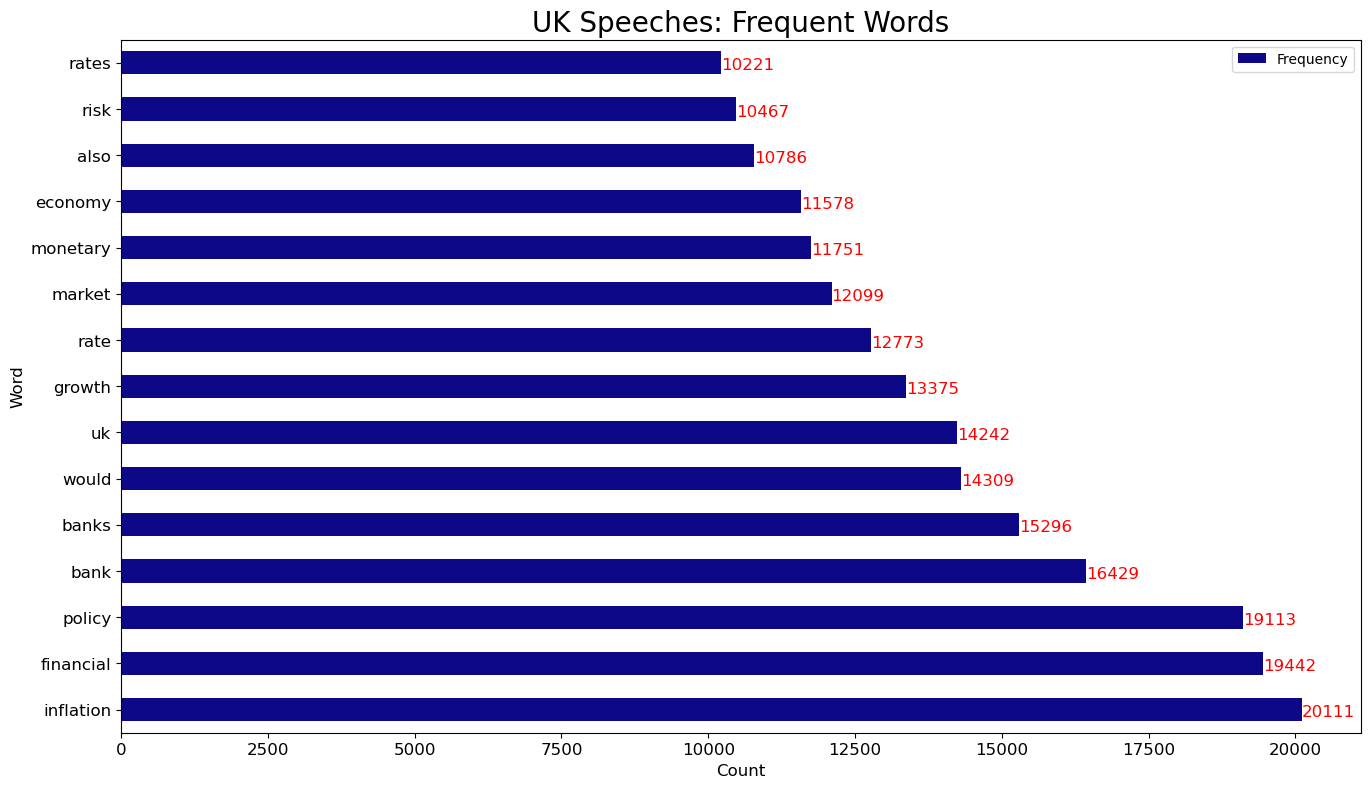

In [68]:
# Determine the 15 most common words.
# Set the plot type.
ax = filtered_counts.plot(kind='barh', figsize=(16, 9), fontsize=12,
                 colormap ='plasma')

# Set the labels.
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('Word', fontsize=12)
ax.set_title("UK Speeches: Frequent Words",
             fontsize=20)

# Draw the bar labels.
for i in ax.patches:
    ax.text(i.get_width()+.41, i.get_y()+.1, str(round((i.get_width()), 2)),
            fontsize=12, color='red')

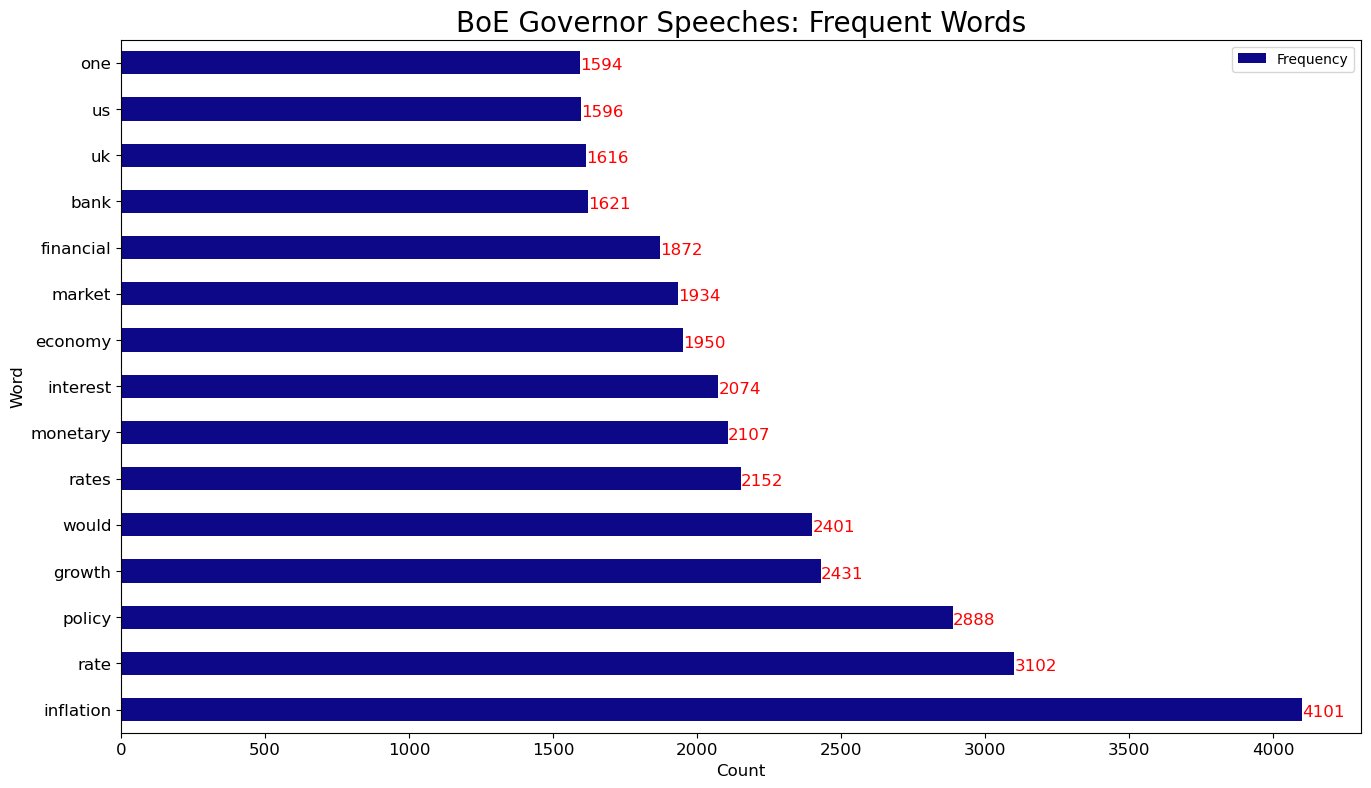

In [69]:
# Determine the 15 most common words.
# Set the plot type.
ax = uk_gov_counts.plot(kind='barh', figsize=(16, 9), fontsize=12,
                 colormap ='plasma')

# Set the labels.
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('Word', fontsize=12)
ax.set_title("BoE Governor Speeches: Frequent Words",
             fontsize=20)

# Draw the bar labels.
for i in ax.patches:
    ax.text(i.get_width()+.41, i.get_y()+.1, str(round((i.get_width()), 2)),
            fontsize=12, color='red')

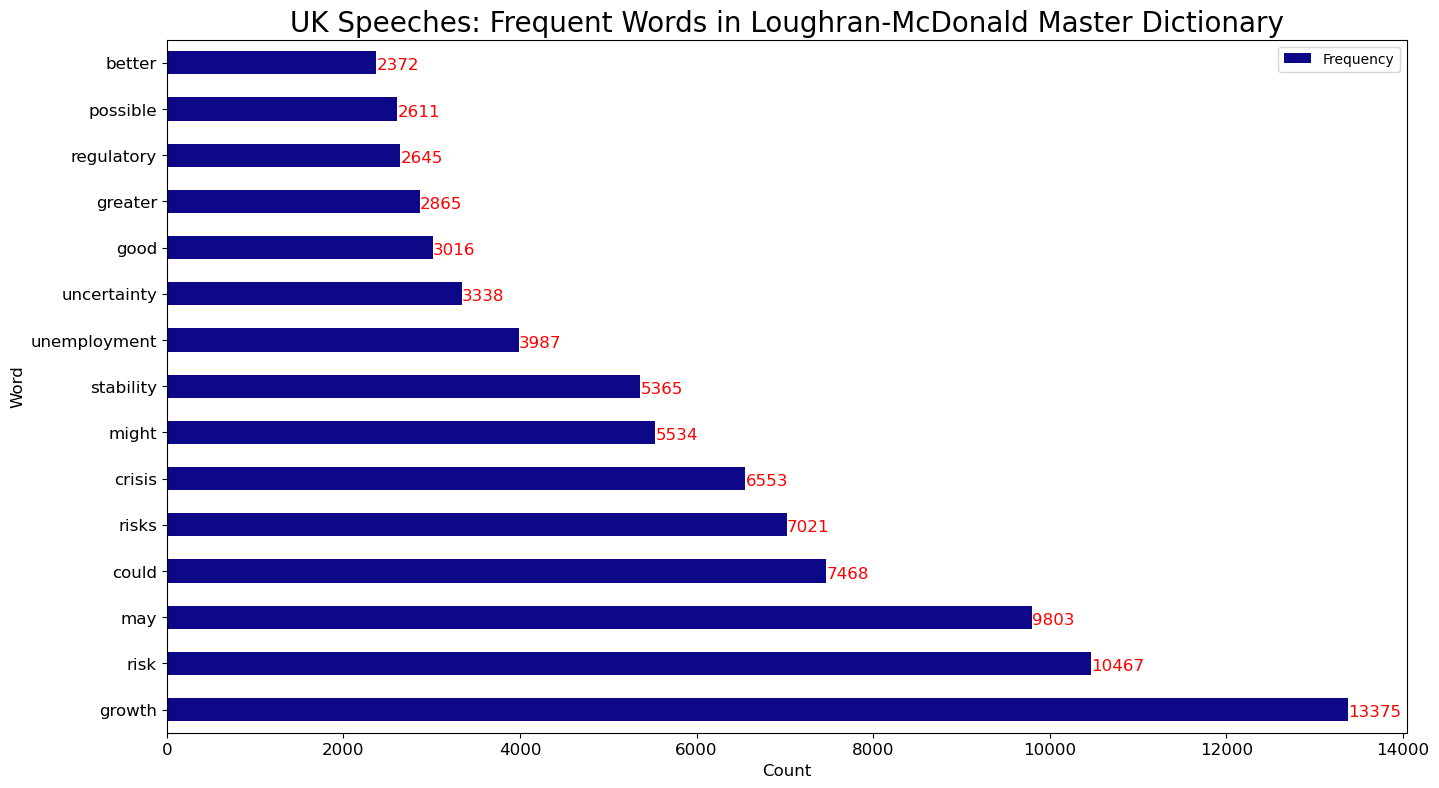

In [70]:
# Determine the 15 most common words.
# Set the plot type.
ax = lm_counts.plot(kind='barh', figsize=(16, 9), fontsize=12,
                 colormap ='plasma')

# Set the labels.
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('Word', fontsize=12)
ax.set_title("UK Speeches: Frequent Words in Loughran-McDonald Master Dictionary",
             fontsize=20)

# Draw the bar labels.
for i in ax.patches:
    ax.text(i.get_width()+.41, i.get_y()+.1, str(round((i.get_width()), 2)),
            fontsize=12, color='red')

### Data Excluding UK

In [71]:
# Subset speeches of different regions
df_eu = df[df['country']=='euro area'].reset_index()
df_us = df[df['country']=='united states'].reset_index()
df_jp = df[df['country']=='japan'].reset_index()
df_ca = df[df['country']=='canada'].reset_index()
df_au = df[df['country']=='australia'].reset_index()
df_se = df[df['country']=='sweden'].reset_index()
df_ch = df[df['country']=='switzerland'].reset_index()

In [72]:
# View Australia
df_au.head()

,index,reference,country,date,quarter,year_month,weekday,year,title,author,is_gov,text,len
0,0,r901128a_BOA,australia,1990-11-28,1990Q4,1990-11,Wednesday,1990,A Proper Role for Monetary Policy,fraser,0,They would no doubt argue that to have two obj...,21288
1,1,r911003a_BOA,australia,1991-10-03,1991Q4,1991-10,Thursday,1991,,fraser,0,Today I wish to talk about real interest rates...,18838
2,2,r920314a_BOA,australia,1992-03-14,1992Q1,1992-03,Saturday,1992,,fraser,0,I welcome this opportunity to talk about prosp...,21100
3,3,r920529a_BOA,australia,1992-05-29,1992Q2,1992-05,Friday,1992,,fraser,0,It is a pleasure to have this opportunity to a...,23608
4,4,r920817a_BOA,australia,1992-08-17,1992Q3,1992-08,Monday,1992,,fraser,0,"As a long-time fan of Don Sanders, I am deligh...",25337


### Analysing Sentiment: VADER Model

**Observation:** The below code block runs the VADER model on each speech. Due to run time it's been run once, exported to a CSV and re-imported.

In [73]:
# Sentiment intensity analysis using VADER sentiment
# sia = SentimentIntensityAnalyzer()

# DataFrame to store results
# sentiment_scores = {
#   'neg': [],
#   'neu': [],
#   'pos': [],
#   'compound': []
# }

# Reset index
# df_uk = df_uk.reset_index(drop=True)

# Loop through the DataFrame
# for j in df_uk.index:
    # Perform sentiment analysis on the 'text' column
    #score = sia.polarity_scores(df_uk.loc[j, 'text'])

     # Append the scores to the lists
#   sentiment_scores['neg'].append(score['neg'])
#   sentiment_scores['neu'].append(score['neu'])
#   sentiment_scores['pos'].append(score['pos'])
#   sentiment_scores['compound'].append(score['compound'])

# New DataFrame
# dft = pd.DataFrame(sentiment_scores)

# Concatenate the sentiment scores with the original DataFrame
# uk_speech_sentiment = pd.concat([df_uk, dft], axis=1)

# View the updated DataFrame with sentiment scores
# uk_speech_sentiment.head()

In [74]:
# Save the DataFrame as an CSV file
# uk_speech_sentiment.to_csv('uk_speech_sentiment.csv', index=False)

### Analysing Sentiment: TextBlob Model

In [75]:
# Read CSV
uk_speech_sentiment = pd.read_csv('uk_speech_sentiment.csv')

In [76]:
# Using a self defined function with Textblob to calculate polarity and subjectivity.
def generate_polarity_subjectivity (df):
    dft2 = TextBlob(df).sentiment
    return pd.Series([dft2[0],dft2[1]])

# Apply the function to the data and add two new columns
uk_speech_sentiment[['polarity','subjectivity']] = uk_speech_sentiment['text'].apply(generate_polarity_subjectivity)
uk_speech_sentiment.head(2)

,reference,country,date,year_month,weekday,year,title,author,is_gov,text,len,speech_tokens,filtered_tokens,neg,neu,pos,compound,polarity,subjectivity
0,r980915a_BOE,united kingdom,1998-09-15,1998-09,Tuesday,1998,Speech,george,0,thank you chairman im actually very pleased to...,13731,"['thank', 'you', 'chairman', 'im', 'actually',...","['thank', 'chairman', 'im', 'actually', 'pleas...",0.082,0.823,0.095,0.9946,0.083288,0.435206
1,r981021b_BOE,united kingdom,1998-10-21,1998-10,Wednesday,1998,Britain in Europe,george,0,its a great pleasure to be here in the beautif...,24263,"['its', 'a', 'great', 'pleasure', 'to', 'be', ...","['great', 'pleasure', 'beautiful', 'city', 'br...",0.067,0.779,0.154,0.9999,0.076711,0.368726


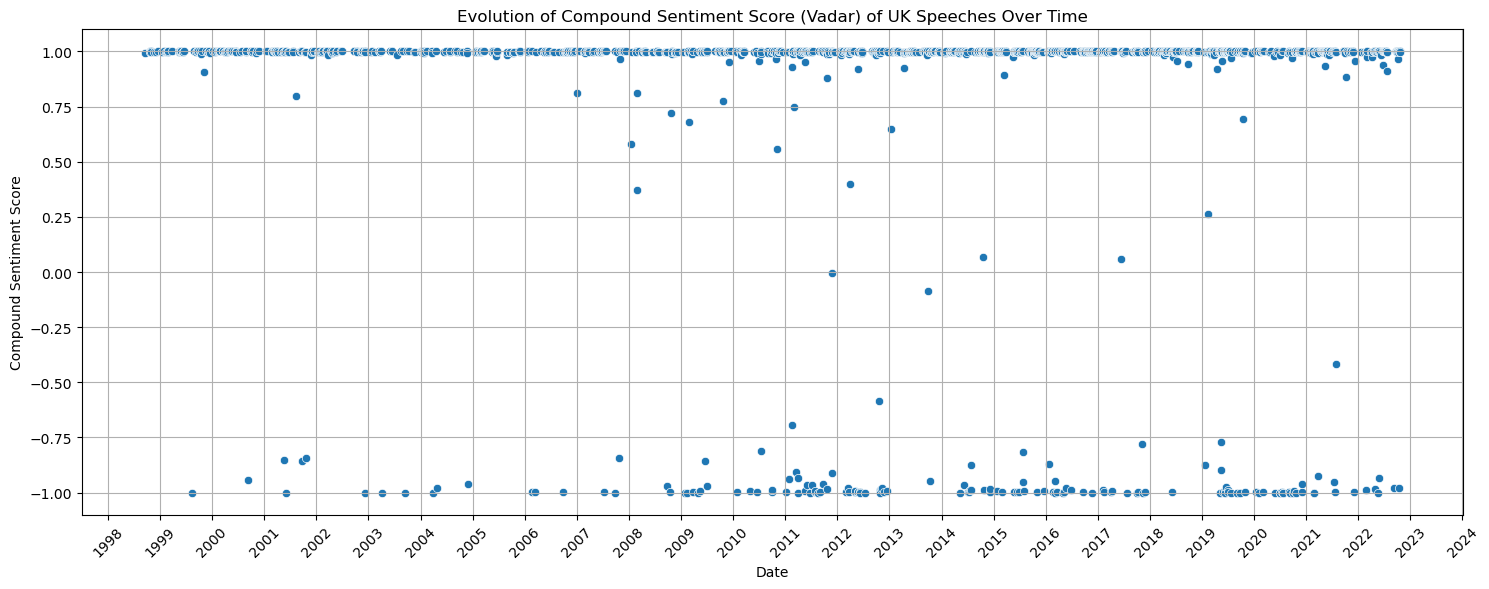

In [77]:
# Import Seaborn
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# Ensure the 'date' column is in datetime format
uk_speech_sentiment['date'] = pd.to_datetime(uk_speech_sentiment['date'])

# Sort by date for a clean time series
uk_speech_sentiment = uk_speech_sentiment.sort_values('date')

# Create a line plot using seaborn and matplotlib
plt.figure(figsize=(15, 6))  # Adjust the figure size if necessary
sns.scatterplot(x='date', y='compound', data=uk_speech_sentiment, marker='o')

# Customize the plot
plt.title('Evolution of Compound Sentiment Score (Vadar) of UK Speeches Over Time')
plt.xlabel('Date')
plt.ylabel('Compound Sentiment Score')
plt.gca().xaxis.set_major_formatter(DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)  # Optional: Add grid for better visibility
plt.tight_layout()  # Adjust layout so that all labels are visible

# Show the plot
plt.show()

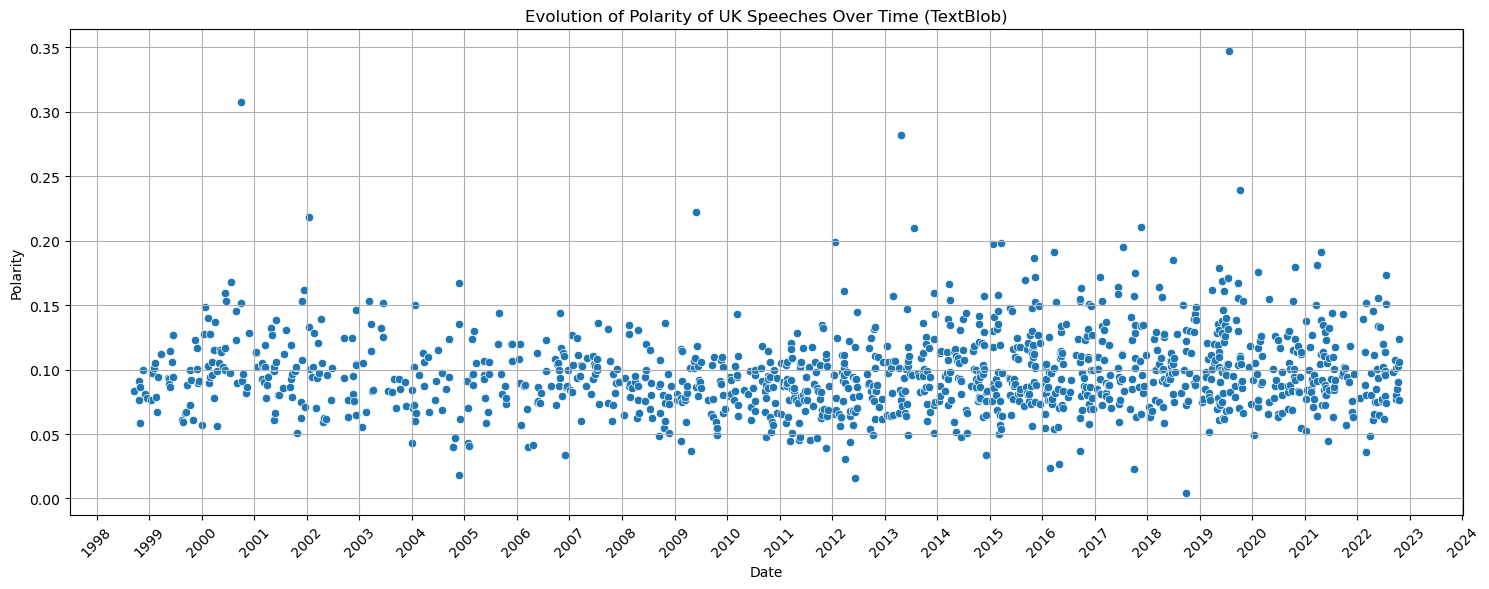

In [78]:
# Import Seaborn
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# Ensure the 'date' column is in datetime format
uk_speech_sentiment['date'] = pd.to_datetime(uk_speech_sentiment['date'])

# Sort by date for a clean time series
uk_speech_sentiment = uk_speech_sentiment.sort_values('date')

# Create a line plot using seaborn and matplotlib
plt.figure(figsize=(15, 6))  # Adjust the figure size if necessary
sns.scatterplot(x='date', y='polarity', data=uk_speech_sentiment, marker='o')

# Customize the plot
plt.title('Evolution of Polarity of UK Speeches Over Time (TextBlob)')
plt.xlabel('Date')
plt.ylabel('Polarity')
plt.gca().xaxis.set_major_formatter(DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)  # Optional: Add grid for better visibility
plt.tight_layout()  # Adjust layout so that all labels are visible

# Show the plot
plt.show()

In [79]:
# Create subset from BOE Governor
gov_speech_sentiment = uk_speech_sentiment[uk_speech_sentiment['is_gov']==1]

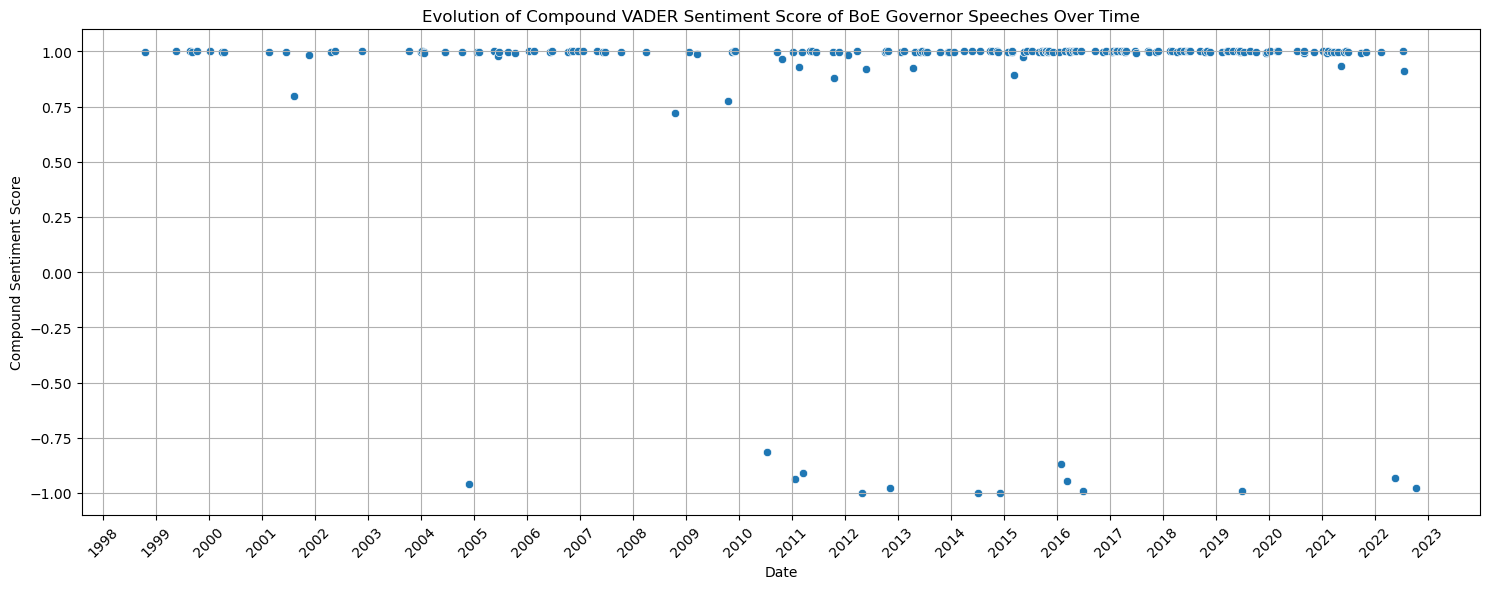

In [80]:
# Import Seaborn
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# Ensure the 'date' column is in datetime format
gov_speech_sentiment['date'] = pd.to_datetime(gov_speech_sentiment['date'])

# Sort by date for a clean time series
gov_speech_sentiment = gov_speech_sentiment.sort_values('date')

# Create a line plot using seaborn and matplotlib
plt.figure(figsize=(15, 6))  # Adjust the figure size if necessary
sns.scatterplot(x='date', y='compound', data=gov_speech_sentiment, marker='o')

# Customize the plot
plt.title('Evolution of Compound VADER Sentiment Score of BoE Governor Speeches Over Time')
plt.xlabel('Date')
plt.ylabel('Compound Sentiment Score')
plt.gca().xaxis.set_major_formatter(DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1)) 
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)  # Optional: Add grid for better visibility
plt.tight_layout()  # Adjust layout so that all labels are visible

# Show the plot
plt.show()

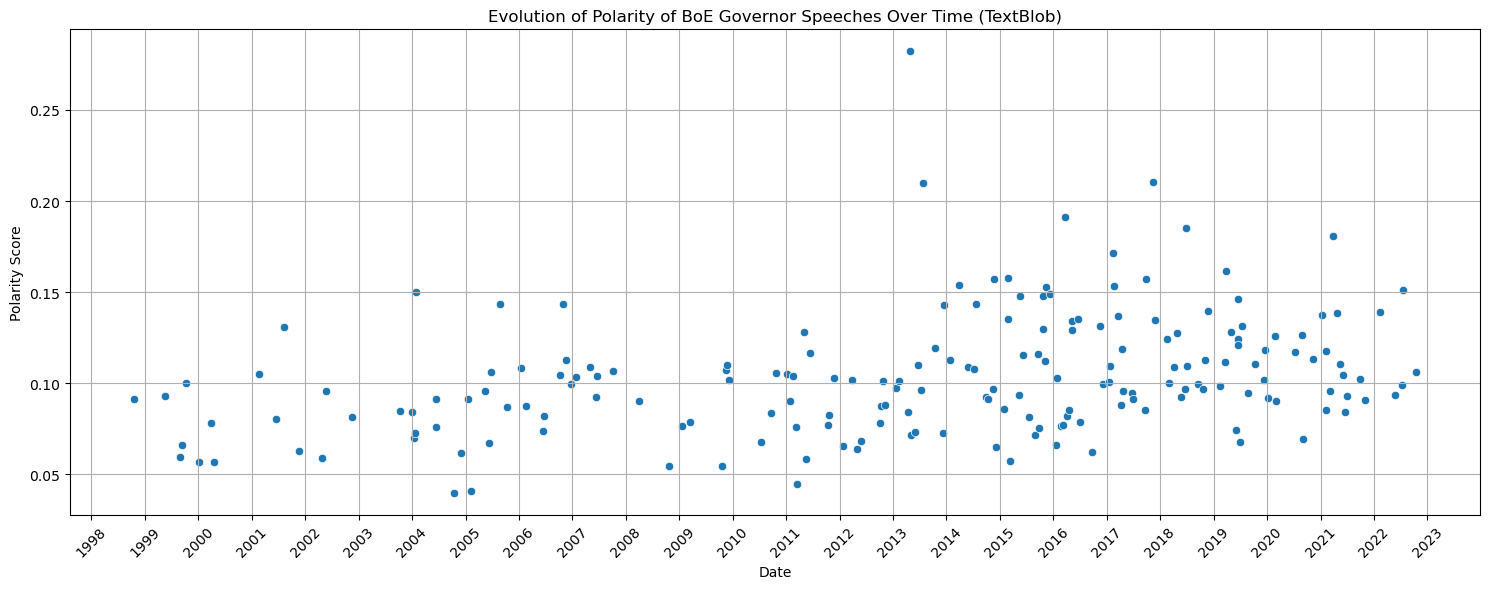

In [81]:
# Import Seaborn
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# Ensure the 'date' column is in datetime format
gov_speech_sentiment['date'] = pd.to_datetime(gov_speech_sentiment['date'])

# Sort by date for a clean time series
gov_speech_sentiment = gov_speech_sentiment.sort_values('date')

# Create a line plot using seaborn and matplotlib
plt.figure(figsize=(15, 6))  # Adjust the figure size if necessary
sns.scatterplot(x='date', y='polarity', data=gov_speech_sentiment, marker='o')

# Customize the plot
plt.title('Evolution of Polarity of BoE Governor Speeches Over Time (TextBlob)')
plt.xlabel('Date')
plt.ylabel('Polarity Score')
plt.gca().xaxis.set_major_formatter(DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1)) 
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)  # Optional: Add grid for better visibility
plt.tight_layout()  # Adjust layout so that all labels are visible

# Show the plot
plt.show()

**Observation:** The VADER and TextBlob NLP models are best suited to social media data. May not be the most accurate for the project context

### Analysing Sentiment: Loughran-McDonald Master Dictionary

In [82]:
# Create dictionaries for sentiment categories
positive_words = set(lm_dict[lm_dict['Positive'] > 0]['Word'])
negative_words = set(lm_dict[lm_dict['Negative'] > 0]['Word'])
uncertain_words = set(lm_dict[lm_dict['Uncertainty'] > 0]['Word'])
litigious_words = set(lm_dict[lm_dict['Litigious'] > 0]['Word'])
strong_words = set(lm_dict[lm_dict['Strong'] > 0]['Word'])
weak_words = set(lm_dict[lm_dict['Weak'] > 0]['Word'])
constraining_words = set(lm_dict[lm_dict['Constraining'] > 0]['Word'])

# Initialize sentiment counts
lm_sentiment_counts = {'positive': 0, 'negative': 0, 'uncertain': 0, 'litigious': 0, 'strong': 0, 'weak': 0, 'constraining': 0}

# Count the sentiment in all tokens
for word in filtered_tokens:
    if word in positive_words:
        lm_sentiment_counts['positive'] += 1
    elif word in negative_words:
        lm_sentiment_counts['negative'] += 1
    elif word in uncertain_words:
        lm_sentiment_counts['uncertain'] += 1
    elif word in litigious_words:
        lm_sentiment_counts['litigious'] += 1
    elif word in strong_words:
        lm_sentiment_counts['strong'] += 1
    elif word in litigious_words:
        lm_sentiment_counts['weak'] += 1
    elif word in constraining_words:
        lm_sentiment_counts['constraining'] += 1

# Print the results
lm_sentiment_counts

{'positive': 74169,
 'negative': 110798,
 'uncertain': 82211,
 'litigious': 16550,
 'strong': 6353,
 'weak': 0,
 'constraining': 14106}

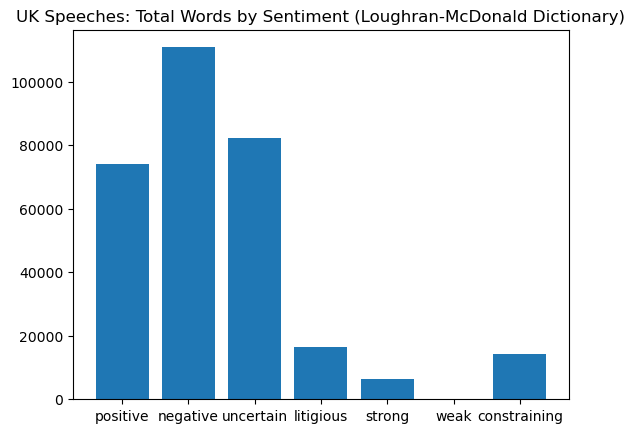

In [83]:
# Quick Plot
plt.bar(*zip(*lm_sentiment_counts.items()))
plt.title("UK Speeches: Total Words by Sentiment (Loughran-McDonald Dictionary)")
plt.show()

In [84]:
# Categorize the words by LM sentiment categories
lm_categories = {
    'Positive': lm_dict[lm_dict['Positive'] == 1]['Word'].str.lower().tolist(),
    'Negative': lm_dict[lm_dict['Negative'] == 1]['Word'].str.lower().tolist(),
    'Uncertainty': lm_dict[lm_dict['Uncertainty'] == 1]['Word'].str.lower().tolist(),
    'Litigious': lm_dict[lm_dict['Litigious'] == 1]['Word'].str.lower().tolist(),
    'Constraining': lm_dict[lm_dict['Constraining'] == 1]['Word'].str.lower().tolist(),
}

In [85]:
# Function to count occurrences of LM words in pre-filtered tokens
def count_sentiment_from_tokens(tokens, lm_categories):
    sentiment_counts = {category: 0 for category in lm_categories.keys()}
    
    # Iterate over the tokens and count occurrences in each category
    for token in tokens:
        for category, words in lm_categories.items():
            if token in words:
                sentiment_counts[category] += 1
    
    return sentiment_counts

**Observation:** The below code block gets the amount of words per sentiment category for each speech. Due to run time it's been run once, exported to a CSV and re-imported.

In [86]:
# Create DataFrame
#lm_sentiment_uk = df_uk.copy()

In [87]:
# Initialize sentiment counts for each speech
#lm_sentiment_uk['sentiment_counts'] = lm_sentiment_uk['filtered_tokens'].apply(lambda x: count_sentiment_from_tokens(x, lm_categories))

# Split the dictionary of counts into separate columns
#sentiment_df = lm_sentiment_uk['sentiment_counts'].apply(pd.Series)

# Merge the counts back into the original dataframe
#lm_sentiment_uk = pd.concat([lm_sentiment_uk, sentiment_df], axis=1)

# Drop column 
#lm_sentiment_uk.drop(columns=['sentiment_counts'], inplace=True)

In [88]:
# Save to CSV
#lm_sentiment_uk.to_csv('lm_sentiment_uk.csv', index=False)

In [89]:
# Import
lm_sentiment_uk = pd.read_csv('lm_sentiment_uk.csv')

# View
lm_sentiment_uk.head()

,reference,country,date,quarter,year_month,weekday,year,title,author,is_gov,...,text,speech_tokens,filtered_tokens,Positive,Negative,Uncertainty,Litigious,Constraining,word_count,sentiment_score
0,r980915a_BOE,united kingdom,1998-09-15,1998Q3,1998-09,Tuesday,1998,Speech,george,0,...,thank you chairman im actually very pleased to...,"['thank', 'you', 'chairman', 'im', 'actually',...","['thank', 'chairman', 'im', 'actually', 'pleas...",39,59,24,3,2,2387,-0.204082
1,r981021b_BOE,united kingdom,1998-10-21,1998Q4,1998-10,Wednesday,1998,Britain in Europe,george,0,...,its a great pleasure to be here in the beautif...,"['its', 'a', 'great', 'pleasure', 'to', 'be', ...","['great', 'pleasure', 'beautiful', 'city', 'br...",82,80,52,6,16,4044,0.012346
2,r981021a_BOE,united kingdom,1998-10-21,1998Q4,1998-10,Wednesday,1998,Impact of the recent turbulence in internation...,king,1,...,few industries have suffered more from volatil...,"['few', 'industries', 'have', 'suffered', 'mor...","['industries', 'suffered', 'volatility', 'brit...",33,61,49,2,5,2311,-0.297872
3,r981101a_BOE,united kingdom,1998-11-01,1998Q4,1998-11,Sunday,1998,"Economic policy, with and without forecasts",budd,0,...,my topic this evening is the use of forecasts ...,"['my', 'topic', 'this', 'evening', 'is', 'the'...","['topic', 'evening', 'use', 'forecasts', 'econ...",43,77,92,11,15,4686,-0.283333
4,r981101b_BOE,united kingdom,1998-11-01,1998Q4,1998-11,Sunday,1998,Inflation targeting in practice: the UK experi...,vickers,0,...,six years ago this week sterling left the exch...,"['six', 'years', 'ago', 'this', 'week', 'sterl...","['six', 'years', 'ago', 'week', 'sterling', 'l...",45,102,119,21,12,4439,-0.387755


- The LM sentiment model has thus far produced 'positive' and 'negative' results as shown in the dataframe above, alongside 'Uncertainty', 'Litigious' and constraining.

- The LM sentiment score is defined as (positive count- negative count) / word count.

- Firstly, we need to ascertain the word count, which can be done as shown below. Note that 'len' exists as a column in the dataframe, but this relates to the character length, not the number of words.

In [90]:
# word-count function
def word_count(text):
    return len(text.split())

# Apply to the text column 
lm_sentiment_uk['word_count'] = lm_sentiment_uk['text'].apply(word_count)

print(lm_sentiment_uk[['text', 'word_count']])

                                                   text  word_count
0     thank you chairman im actually very pleased to...        2387
1     its a great pleasure to be here in the beautif...        4044
2     few industries have suffered more from volatil...        2311
3     my topic this evening is the use of forecasts ...        4686
4     six years ago this week sterling left the exch...        4439
...                                                 ...         ...
1204  thank you very much for the invitation to spea...        4141
1205  huw pill talks about how we will bring inflati...        3564
1206  we are meeting in the most difficult of times ...        1767
1207  these are divided into seven categories suffra...        5324
1208  between them the covid-19 pandemic and russias...        6024

[1209 rows x 2 columns]


**Observation**: We can now check our updated DataFrame, to ensure the word count column has been applied. Now, we can calculate the Sentiment score and add this in to the DataFrame.

In [91]:
# Note that this code below returns the 'true' sentiment score.

#lm_sentiment_uk['sentiment_score'] = (lm_sentiment_uk['Positive'] - lm_sentiment_uk['Negative']) / lm_sentiment_uk['word_count']

# However, due to only a relatively small number of words within each speech matching the LM dictionary for positive and negative values,
# the sentiment score will be normalised (score output of between -1 and 1), to provide clearer illustration and means of measuring polarity.

In [92]:
# Normalised sentiment score
lm_sentiment_uk['sentiment_score'] = (lm_sentiment_uk['Positive'] - lm_sentiment_uk['Negative'])\
/ (lm_sentiment_uk['Positive'] + lm_sentiment_uk['Negative'])

In [93]:
# View
lm_sentiment_uk.head()

,reference,country,date,quarter,year_month,weekday,year,title,author,is_gov,...,text,speech_tokens,filtered_tokens,Positive,Negative,Uncertainty,Litigious,Constraining,word_count,sentiment_score
0,r980915a_BOE,united kingdom,1998-09-15,1998Q3,1998-09,Tuesday,1998,Speech,george,0,...,thank you chairman im actually very pleased to...,"['thank', 'you', 'chairman', 'im', 'actually',...","['thank', 'chairman', 'im', 'actually', 'pleas...",39,59,24,3,2,2387,-0.204082
1,r981021b_BOE,united kingdom,1998-10-21,1998Q4,1998-10,Wednesday,1998,Britain in Europe,george,0,...,its a great pleasure to be here in the beautif...,"['its', 'a', 'great', 'pleasure', 'to', 'be', ...","['great', 'pleasure', 'beautiful', 'city', 'br...",82,80,52,6,16,4044,0.012346
2,r981021a_BOE,united kingdom,1998-10-21,1998Q4,1998-10,Wednesday,1998,Impact of the recent turbulence in internation...,king,1,...,few industries have suffered more from volatil...,"['few', 'industries', 'have', 'suffered', 'mor...","['industries', 'suffered', 'volatility', 'brit...",33,61,49,2,5,2311,-0.297872
3,r981101a_BOE,united kingdom,1998-11-01,1998Q4,1998-11,Sunday,1998,"Economic policy, with and without forecasts",budd,0,...,my topic this evening is the use of forecasts ...,"['my', 'topic', 'this', 'evening', 'is', 'the'...","['topic', 'evening', 'use', 'forecasts', 'econ...",43,77,92,11,15,4686,-0.283333
4,r981101b_BOE,united kingdom,1998-11-01,1998Q4,1998-11,Sunday,1998,Inflation targeting in practice: the UK experi...,vickers,0,...,six years ago this week sterling left the exch...,"['six', 'years', 'ago', 'this', 'week', 'sterl...","['six', 'years', 'ago', 'week', 'sterling', 'l...",45,102,119,21,12,4439,-0.387755


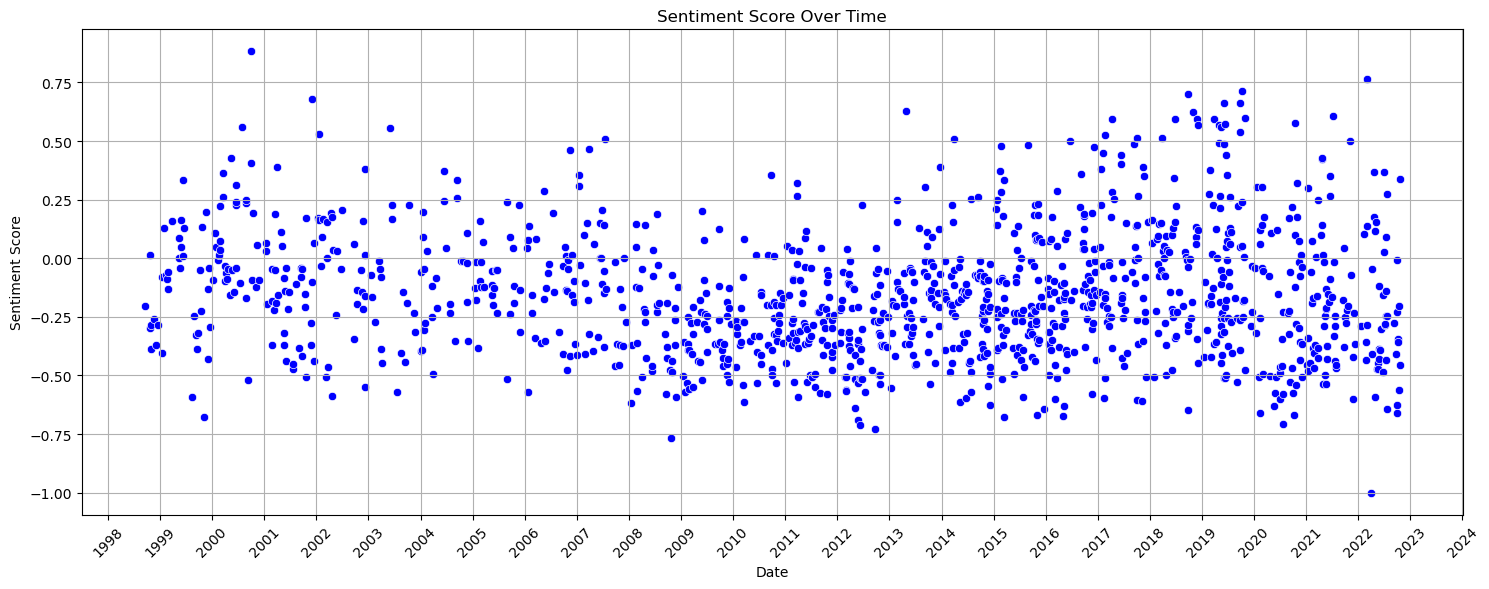

In [94]:
# Plot
lm_sentiment_uk['date'] = pd.to_datetime(lm_sentiment_uk['date'])

plt.figure(figsize=(15,6))

sns.scatterplot(x=lm_sentiment_uk['date'], y=lm_sentiment_uk['sentiment_score'], color='blue')

plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.gca().xaxis.set_major_formatter(DateFormatter("%Y"))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1)) 
plt.title('Sentiment Score Over Time')
plt.grid(True)

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Above, we have plotted the (normalised) sentiment scores using the LM dictionary.

There appears to be no obvious trend, with an array of results, whose fluctuation appears to be sporadic and not follow a trend overtime. 

We note a particularly negative score towards the beginning of 2022, whereby -1 sentiment score was achieved, indicating that according to the LM dictionary, the speech was entirely negative!

We can also inspect in closer detail, the previous 5 years of data below:

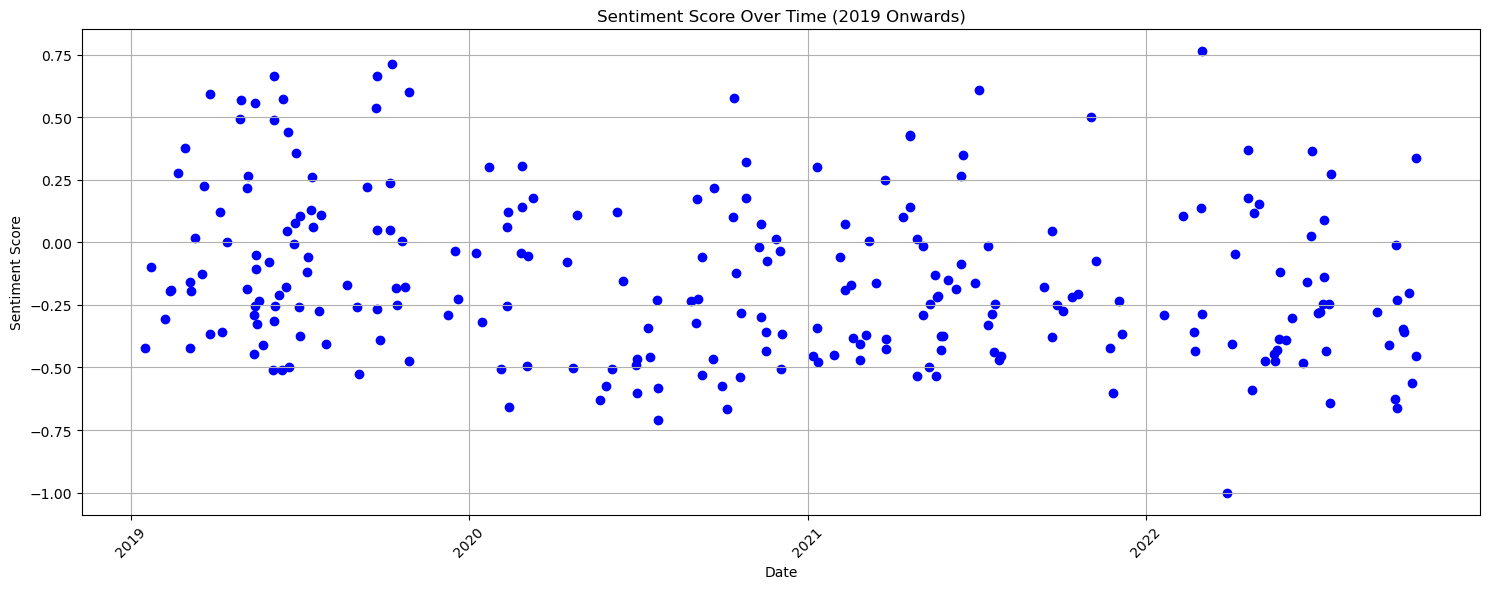

In [95]:
# Filter the DataFrame for dates from 2019 onwards
filtered_df = lm_sentiment_uk[lm_sentiment_uk['date'] >= '2019-01-01']

plt.figure(figsize=(15,6))
plt.scatter(filtered_df['date'], filtered_df['sentiment_score'], color='blue', marker='o')

plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.gca().xaxis.set_major_formatter(DateFormatter("%Y"))  # Format the x-axis labels as years
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Place major ticks at every year
plt.xticks(rotation=45)
plt.title('Sentiment Score Over Time (2019 Onwards)')
plt.grid(True)

plt.tight_layout()
plt.show()

Again however, not much clarity of trend in speech sentiment overtime. 

Although, we can assign an average sentiment score across the various years:

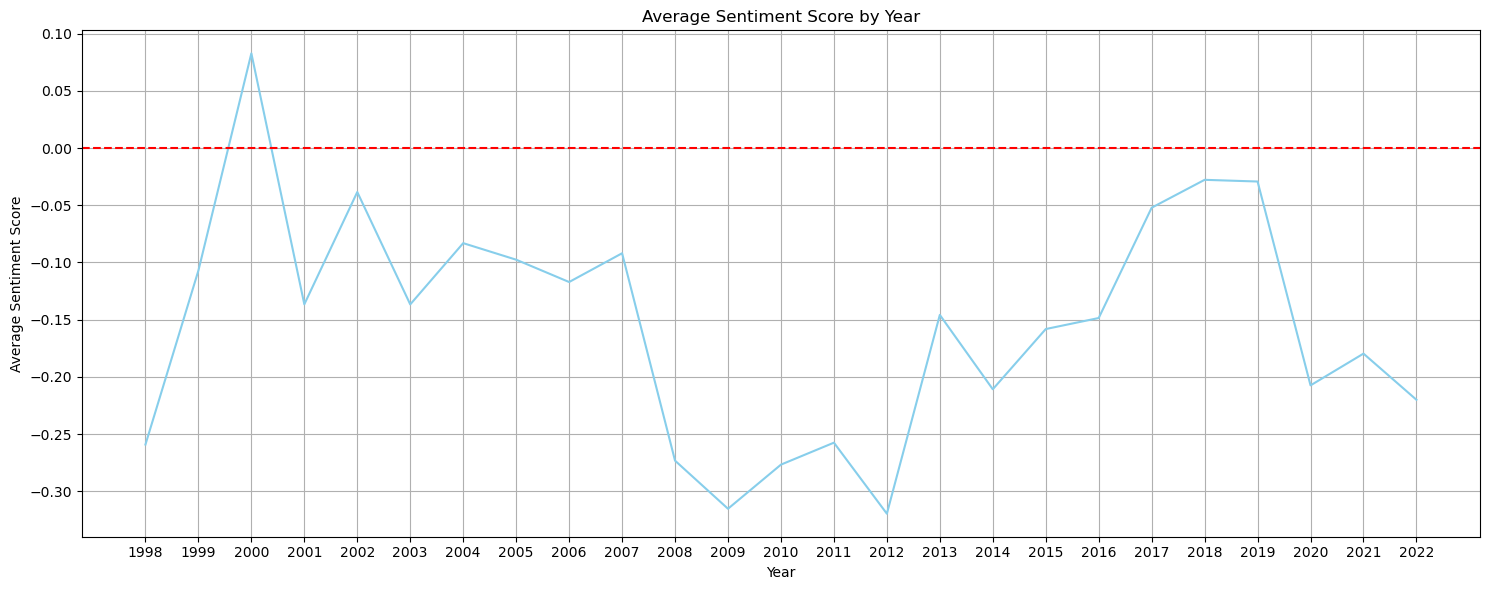

In [96]:
# Extract the year from the 'date' column and create a new column 'year'
lm_sentiment_uk['year'] = lm_sentiment_uk['date'].dt.year

# Group by 'year' and calculate the mean sentiment score
average_sentiment_by_year = lm_sentiment_uk.groupby('year')['sentiment_score'].mean().reset_index()

plt.figure(figsize=(15,6))

# Plot the average sentiment score by year
plt.plot(average_sentiment_by_year['year'], average_sentiment_by_year['sentiment_score'], color='skyblue')

plt.axhline(y=0.00, color='red', linestyle='--', label='y=0.00')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score by Year')
plt.grid(True)
plt.xticks(average_sentiment_by_year['year'])  # Show all years on x-axis
plt.tight_layout()
plt.show()

#### Simple Moving Average (SMA)

In [97]:
# Import necessary modules
from sklearn.metrics import mean_absolute_error

# Function to plot moving average
# Scale - The default value corresponds to a 95% confidence interval assuming a normal distribution
def plot_moving_average(series, window):

    rolling_mean = series.rolling(window=window).mean()

    dates = pd.date_range(start="1998-01-01", end="2022-12-01", freq="AS")
    values = range(len(dates))

    plt.figure(figsize=(16,6))
    plt.title("Moving Average\n Window Size = {}".format(window))
    plt.ylabel('FinBERT Sentiment Score', color='black')
    plt.plot(rolling_mean, color='blue')

    # Date format
    ax = plt.gca()
    selected_years = [year for year in range(1998, 2023, 2)]
    ax.set_xticks(pd.to_datetime(selected_years, format='%Y'))
    date_format = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_formatter(date_format)
    plt.xticks(color='black')
    plt.yticks(color='black')
    
    plt.grid(True)

In [98]:
# Convert to DateTime
lm_sentiment_uk['year_month'] = pd.to_datetime(lm_sentiment_uk['year_month'], format='%Y-%m')

In [99]:
# Create monthly DataFrame
lm_sentiment_month = pd.DataFrame(lm_sentiment_uk.groupby('year_month')['sentiment_score'].mean())

<Figure size 2000x600 with 0 Axes>

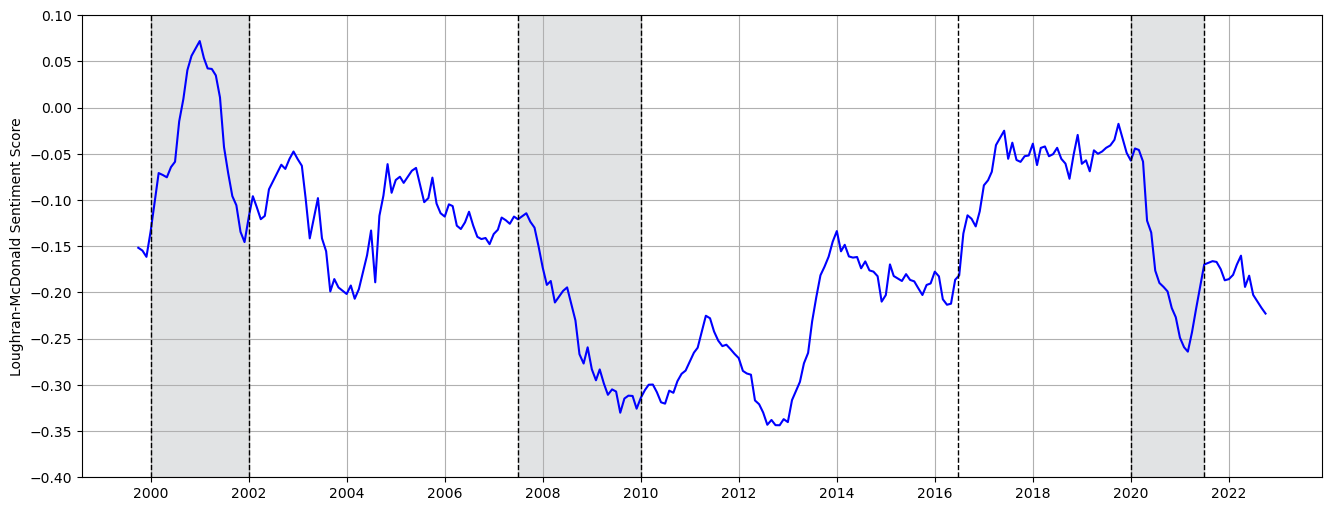

In [100]:
# 12 Month
plt.figure(figsize=(20, 6))
ax = plot_moving_average(lm_sentiment_month, 12)
plt.yticks(np.arange(-0.4, 0.15, 0.05))

plt.title("", color="black")
plt.ylabel('Loughran-McDonald Sentiment Score')

plt.axvspan(
    pd.to_datetime('2007-07-01'), pd.to_datetime('2010-01-01'),
    color='#B4B9BC', alpha=0.4
)

plt.axvspan(
    pd.to_datetime('2000-01-01'), pd.to_datetime('2002-01-01'),
    color='#B4B9BC', alpha=0.4
)

plt.axvline(pd.to_datetime('2016-06-23'), linestyle='--', color='black', linewidth=1)
plt.axvline(pd.to_datetime('2007-07-01'), linestyle='--', color='black', linewidth=1)
plt.axvline(pd.to_datetime('2010-01-01'), linestyle='--', color='black', linewidth=1)
plt.axvline(pd.to_datetime('2002-01-01'), linestyle='--', color='black', linewidth=1)
plt.axvline(pd.to_datetime('2000-01-01'), linestyle='--', color='black', linewidth=1)
plt.axvline(pd.to_datetime('2020-01-01'), linestyle='--', color='black', linewidth=1)
plt.axvline(pd.to_datetime('2021-07-01'), linestyle='--', color='black', linewidth=1)

plt.axvspan(
    pd.to_datetime('2020-01-01'), pd.to_datetime('2021-07-01'),
    color='#B4B9BC', alpha=0.4
)
        
plt.savefig('12-Month_SMA_LM.png')

### Analysing Sentiment: FinBERT Model

In [101]:
# View
df_uk.head(2)

,reference,country,date,quarter,year_month,weekday,year,title,author,is_gov,len,text,speech_tokens,filtered_tokens
0,r980915a_BOE,united kingdom,1998-09-15,1998Q3,1998-09,Tuesday,1998,Speech,george,0,13731,thank you chairman im actually very pleased to...,"[thank, you, chairman, im, actually, very, ple...","[thank, chairman, im, actually, pleased, oppor..."
1,r981021b_BOE,united kingdom,1998-10-21,1998Q4,1998-10,Wednesday,1998,Britain in Europe,george,0,24263,its a great pleasure to be here in the beautif...,"[its, a, great, pleasure, to, be, here, in, th...","[great, pleasure, beautiful, city, bruges, hon..."


In [102]:
# Install
# !pip install transformers

In [103]:
import scipy
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [104]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [105]:
def finbert_sentiment(text: str) -> tuple[float, float, float, str]:
    with torch.no_grad():
        
        # Tokenize the input text
        inputs = tokenizer(
            text, return_tensors="pt", padding=True, truncation=True, max_length=512
        )
        
        # Forward pass through the model
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Calculate softmax scores
        softmax_scores = scipy.special.softmax(logits.numpy(), axis=1).squeeze()

        # Create a dictionary with the sentiment scores
        scores = {
            model.config.id2label[i]: softmax_scores[i] for i in range(len(softmax_scores))
        }

        # Return the scores for positive, negative, and neutral, along with the predicted sentiment
        return (
            scores.get('positive', 0.0),
            scores.get('negative', 0.0),
            scores.get('neutral', 0.0),
            max(scores, key=scores.get),
        )

**Observation:** The below code block runs the FinBERT model on the UK subset. Due to run time it's been run once, exported to a CSV and re-imported.

In [106]:
# Copy
# bert_sentiment_uk = df_uk.copy()

In [107]:
# Run the function on the UK subset
#bert_sentiment_uk[['finbert_pos', 'finbert_neg', 'finbert_neu', 'finbert_sentiment']] = (
#    bert_sentiment_uk['text'].apply(finbert_sentiment).apply(pd.Series)
#)

#bert_sentiment_uk['finbert_score'] = bert_sentiment_uk['finbert_pos'] - bert_sentiment_uk['finbert_neg']

In [108]:
# Save to CSV
#bert_sentiment_uk.to_csv('bert_sentiment_uk.csv', index=False)

In [109]:
# Import
bert_sentiment_uk = pd.read_csv('bert_sentiment_uk.csv')

In [110]:
# View
bert_sentiment_uk.head(5)

,reference,country,date,quarter,year_month,weekday,year,title,author,is_gov,len,text,speech_tokens,filtered_tokens,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,finbert_score,team_sentiment
0,r980915a_BOE,united kingdom,1998-09-15,1998Q3,1998-09-01,Tuesday,1998,Speech,george,0,13731,thank you chairman im actually very pleased to...,"['thank', 'you', 'chairman', 'im', 'actually',...","['thank', 'chairman', 'im', 'actually', 'pleas...",0.087535,0.325207,0.587258,neutral,-0.237672,neutral-negative
1,r981021b_BOE,united kingdom,1998-10-21,1998Q4,1998-10-01,Wednesday,1998,Britain in Europe,george,0,24263,its a great pleasure to be here in the beautif...,"['its', 'a', 'great', 'pleasure', 'to', 'be', ...","['great', 'pleasure', 'beautiful', 'city', 'br...",0.212209,0.017505,0.770286,neutral,0.194704,neutral-positive
2,r981021a_BOE,united kingdom,1998-10-21,1998Q4,1998-10-01,Wednesday,1998,Impact of the recent turbulence in internation...,king,1,13678,few industries have suffered more from volatil...,"['few', 'industries', 'have', 'suffered', 'mor...","['industries', 'suffered', 'volatility', 'brit...",0.047679,0.476351,0.475970,negative,-0.428672,negative
3,r981101a_BOE,united kingdom,1998-11-01,1998Q4,1998-11-01,Sunday,1998,"Economic policy, with and without forecasts",budd,0,27679,my topic this evening is the use of forecasts ...,"['my', 'topic', 'this', 'evening', 'is', 'the'...","['topic', 'evening', 'use', 'forecasts', 'econ...",0.046829,0.049165,0.904007,neutral,-0.002336,neutral
4,r981101b_BOE,united kingdom,1998-11-01,1998Q4,1998-11-01,Sunday,1998,Inflation targeting in practice: the UK experi...,vickers,0,27693,six years ago this week sterling left the exch...,"['six', 'years', 'ago', 'this', 'week', 'sterl...","['six', 'years', 'ago', 'week', 'sterling', 'l...",0.035134,0.049842,0.915023,neutral,-0.014708,neutral


**Observation:** The model calculates the probability of a speech being positive, negative, or neutral
- It assigns a sentiment category based on the highest probability
- The sentiment score is calculated by taking the probability of the speech being positive, and subtracting the probability of the speech being negative

In [111]:
# Shape
bert_sentiment_uk.shape

# Convert to DateTime
bert_sentiment_uk['date'] = pd.to_datetime(bert_sentiment_uk['date'])
bert_sentiment_uk['year_month'] = pd.to_datetime(bert_sentiment_uk['year_month'])
bert_sentiment_uk['quarter'] = pd.PeriodIndex(bert_sentiment_uk['date'], freq='Q')

In [112]:
# Function for new classification
def classify_neu(row):

    sentiment = row['finbert_sentiment']
    score = row['finbert_score']

    if sentiment == 'neutral':
        if score > 0.1:
            return 'neutral-positive'
        elif score < -0.1:
            return 'neutral-negative'
        else:
            return 'neutral'
    else:
        return sentiment

# Apply function 
bert_sentiment_uk['team_sentiment'] = bert_sentiment_uk.apply(classify_neu, axis=1)

**Observation:** Have added a new column, with 2 additional classifications:
- Speeches classified by FinBERT as neutral but with over 0.1 sentiment score are 'Neutral-Positive'
- Speeches classified by FinBERT as neutral but with under 0.1 sentiment score are 'Neutral-Negative'

In [113]:
# View
bert_sentiment_uk.head(2)

,reference,country,date,quarter,year_month,weekday,year,title,author,is_gov,len,text,speech_tokens,filtered_tokens,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,finbert_score,team_sentiment
0,r980915a_BOE,united kingdom,1998-09-15,1998Q3,1998-09-01,Tuesday,1998,Speech,george,0,13731,thank you chairman im actually very pleased to...,"['thank', 'you', 'chairman', 'im', 'actually',...","['thank', 'chairman', 'im', 'actually', 'pleas...",0.087535,0.325207,0.587258,neutral,-0.237672,neutral-negative
1,r981021b_BOE,united kingdom,1998-10-21,1998Q4,1998-10-01,Wednesday,1998,Britain in Europe,george,0,24263,its a great pleasure to be here in the beautif...,"['its', 'a', 'great', 'pleasure', 'to', 'be', ...","['great', 'pleasure', 'beautiful', 'city', 'br...",0.212209,0.017505,0.770286,neutral,0.194704,neutral-positive


Text(0.5, 1.0, 'Total UK Speeches by FinBERT Sentiment Category')

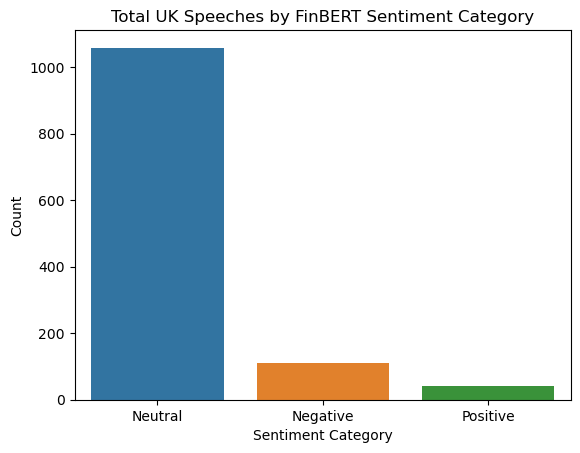

In [114]:
# Plot
ax = sns.countplot(x='finbert_sentiment', data=bert_sentiment_uk)

# Set labels
plt.xlabel('Sentiment Category')
plt.ylabel('Count')

# X labels
ax.set_xticklabels(['Neutral', 'Negative', 'Positive'])

# Set title
plt.title('Total UK Speeches by FinBERT Sentiment Category')

In [115]:
# Sentiment distribution (All speeches)
bert_counts = bert_sentiment_uk['finbert_sentiment'].value_counts()

# Calculate the percentage distribution
print((bert_counts / bert_counts.sum()) * 100)

finbert_sentiment
neutral     87.510339
negative     9.181141
positive     3.308519
Name: count, dtype: float64


**Observation:** A significant proportion of the UK speeches are classified as 'Neutral' (87.5%)

Text(0.5, 1.0, 'Total UK Speeches by Team Sentiment Category')

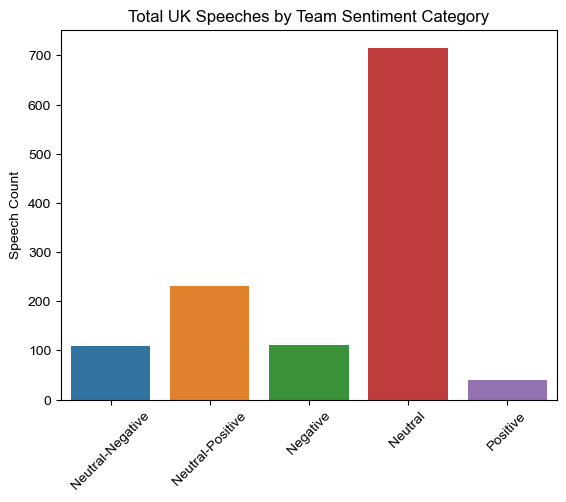

In [116]:
# Plot
ax = sns.countplot(x='team_sentiment', data=bert_sentiment_uk)

sns.set(style="whitegrid")

# Set labels
plt.xlabel('')
plt.ylabel('Speech Count')

# X labels
ax.set_xticklabels(['Neutral-Negative', 'Neutral-Positive', 'Negative', 'Neutral', 'Positive'], rotation=45)

# Set title
plt.title('Total UK Speeches by Team Sentiment Category')

In [117]:
# Sentiment distribution (All speeches)
team_counts = bert_sentiment_uk['team_sentiment'].value_counts()

# Calculate the percentage distribution
percent_dist = pd.DataFrame((team_counts / team_counts.sum()) * 100).reset_index()

# Rename
percent_dist.rename(columns={'count': 'percent'}, inplace=True)

# Reorder
categories = ['negative', 'neutral-negative', 'neutral', 'neutral-positive', 'neutral-positive', 'positive']
mapping = {cat: i for i, cat in enumerate(categories)}
key = percent_dist['team_sentiment'].map(mapping)

# Apply
percent_dist = percent_dist.iloc[key.argsort()].reset_index(drop=True)

In [118]:
# Sentiment distribution (All speeches)
team_counts_gov = bert_sentiment_uk[bert_sentiment_uk['is_gov'] == 1]['team_sentiment'].value_counts()

# Calculate the percentage distribution
percent_dist_gov = pd.DataFrame((team_counts_gov / team_counts_gov.sum()) * 100).reset_index()

# Rename
percent_dist_gov.rename(columns={'count': 'percent'}, inplace=True)

# Reorder
categories = ['negative', 'neutral-negative', 'neutral', 'neutral-positive', 'neutral-positive', 'positive']
mapping = {cat: i for i, cat in enumerate(categories)}
key = percent_dist_gov['team_sentiment'].map(mapping)

# Apply
percent_dist_gov = percent_dist_gov.iloc[key.argsort()].reset_index(drop=True)

In [119]:
percent_dist_gov

,team_sentiment,percent
0,negative,6.842105
1,neutral-negative,6.315789
2,neutral,57.894737
3,neutral-positive,26.842105
4,positive,2.105263


In [120]:
percent_dist

,team_sentiment,percent
0,negative,9.181141
1,neutral-negative,9.098428
2,neutral,59.222498
3,neutral-positive,19.189413
4,positive,3.308519


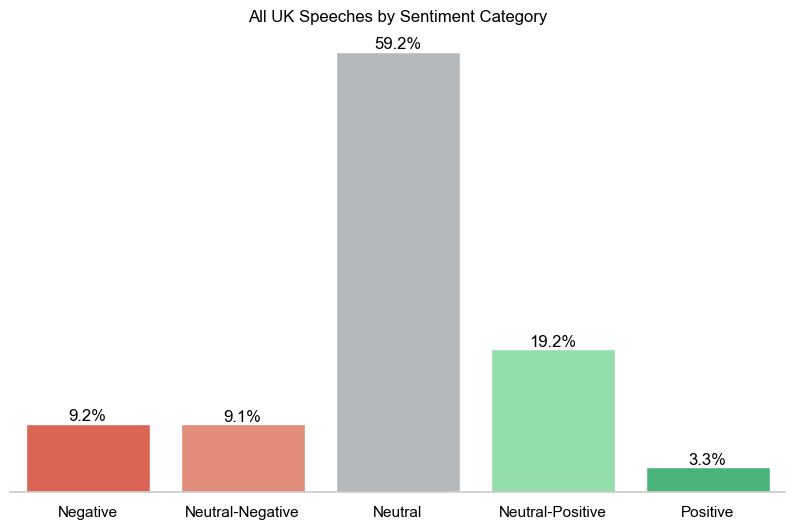

In [121]:
# Plot
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=percent_dist, x="team_sentiment", y="percent", palette=['#F2543D', '#F28268', '#B4B9BC', '#87EBA8', '#38C477'])

sns.set(style="whitegrid")

x_ticks = ['negative', 'neutral-negative', 'neutral', 'neutral-positive', 'positive']
x_tick_labels = ['Negative', 'Neutral-Negative', 'Neutral', 'Neutral-Positive', 'Positive']

# Set the x-ticks
ax.set_xticks(range(len(x_ticks)))
plt.yticks([], [])

# Set the x-tick labels
ax.set_xticklabels(x_tick_labels, color='black')

# Set labels
plt.xlabel('')
plt.ylabel('')

sns.despine(left=True)

# Annotate bars
ax.bar_label(ax.containers[-1], fmt='%.1f%%', color='black')

# Set title
plt.title('All UK Speeches by Sentiment Category', color='black')

plt.savefig('FinBERT_Sent_Cat.png')

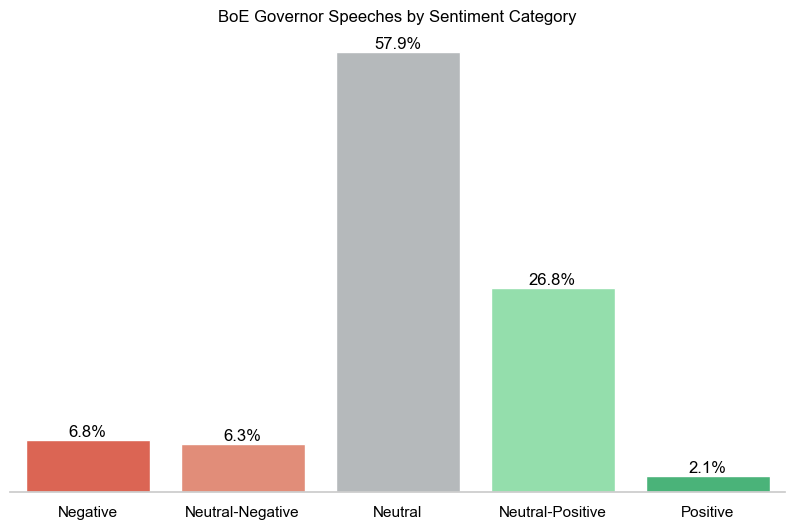

In [122]:
# Plot
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=percent_dist_gov, x="team_sentiment", y="percent", palette=['#F2543D', '#F28268', '#B4B9BC', '#87EBA8', '#38C477'])

sns.set(style="whitegrid")

x_ticks = ['negative', 'neutral-negative', 'neutral', 'neutral-positive', 'positive']
x_tick_labels = ['Negative', 'Neutral-Negative', 'Neutral', 'Neutral-Positive', 'Positive']

# Set the x-ticks
ax.set_xticks(range(len(x_ticks)))
plt.yticks([], [])

# Set the x-tick labels
ax.set_xticklabels(x_tick_labels, color='black')

# Set labels
plt.xlabel('')
plt.ylabel('')

sns.despine(left=True)

# Annotate bars
ax.bar_label(ax.containers[-1], fmt='%.1f%%', color='black')

# Set title
plt.title('BoE Governor Speeches by Sentiment Category', color='black')

plt.savefig('FinBERT_Sent_Gov.png')

**Observation:** Using the ammended sentiment, with additional classifications based on sentiment score (Neutral-Positive / Neutral-Negative), it is more varied. 

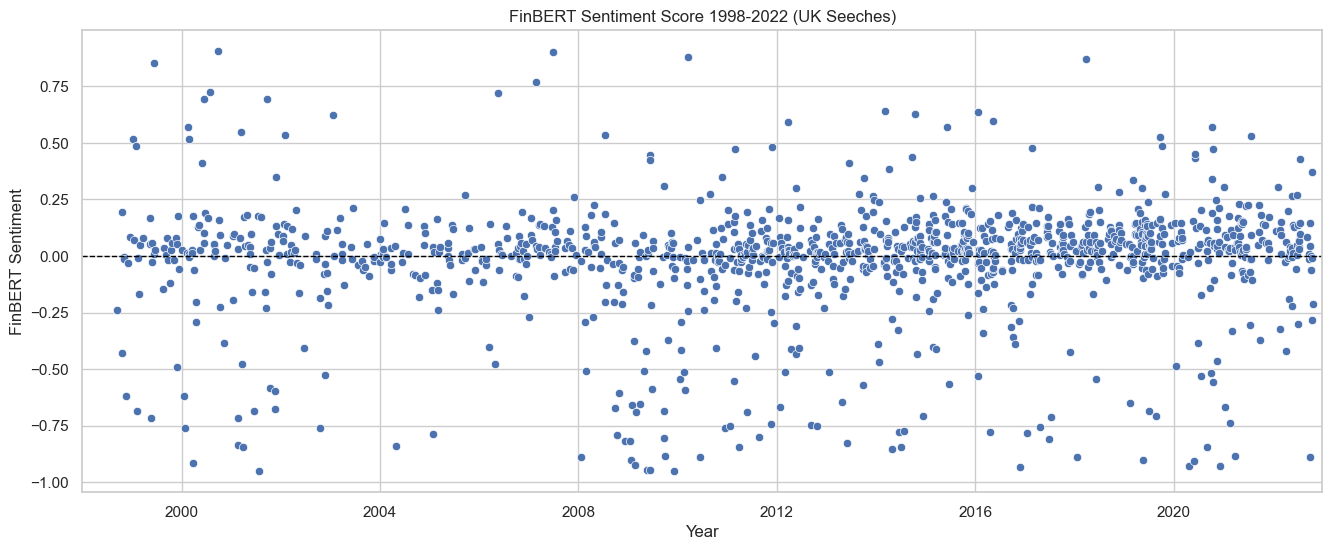

In [123]:
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.scatterplot(data=bert_sentiment_uk, x='date', y='finbert_score', marker ='o')

# Define date format
date_format = mdates.DateFormatter('%Y')

# Set the x-axis
ax.xaxis.set_major_formatter(date_format)

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# X-Axis Limit
ax.set_xlim([pd.Timestamp('1998-01-01'), pd.Timestamp('2022-12-31')])

# Set labels
plt.xlabel('Year')
plt.ylabel('FinBERT Sentiment')

# Set title
plt.title('FinBERT Sentiment Score 1998-2022 (UK Seeches)')

# Display the plot
plt.show()

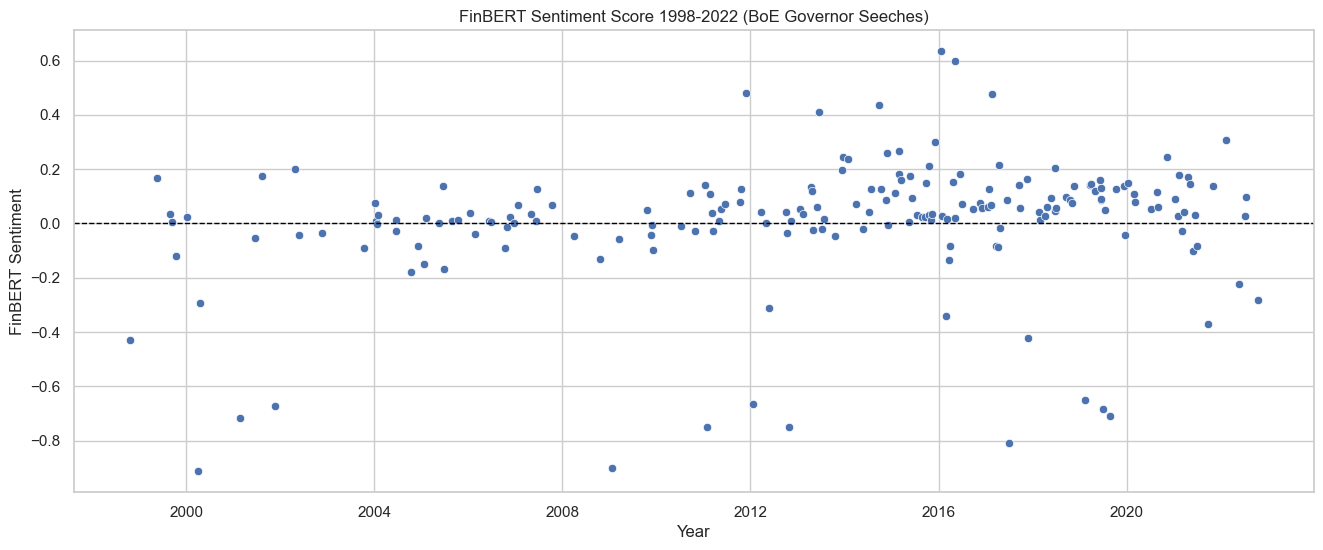

In [124]:
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.scatterplot(data=bert_sentiment_uk[bert_sentiment_uk['is_gov'] == 1], x='date', y='finbert_score', marker ='o')

# Define date format
date_format = mdates.DateFormatter('%Y')

# Set the x-axis
ax.xaxis.set_major_formatter(date_format)

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Set labels
plt.xlabel('Year')
plt.ylabel('FinBERT Sentiment')

# Set title
plt.title('FinBERT Sentiment Score 1998-2022 (BoE Governor Seeches)')

# Display the plot
plt.show()

#### FinBERT Model - Alternative Method (Chunked)

**Observation:** The below code block runs the alternative FinBERT model on the UK subset. Due to run time it's been run once, exported to a CSV and re-imported.
- The model splits the speech into different sections, averaging the score. 

In [125]:
def finbert_sentiment_chunked(text: str) -> tuple[float, float, float, str]:
# Tokenize the input text
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True)['input_ids'][0]
        
    # Function to handle long text by chunking
    all_pos_scores = []
    all_neg_scores = []
    all_neu_scores = []

    # Chunk the tokens list by 512 tokens each
    for i in range(0, len(tokens), 512):
        chunk = tokens[i:i+512]
        
        # Add [CLS] and [SEP] tokens if needed
        chunk = torch.cat([torch.tensor([tokenizer.cls_token_id]), chunk, torch.tensor([tokenizer.sep_token_id])])
        
        # Make sure chunk length doesn't exceed 512 after adding special tokens
        if len(chunk) > 512:
            chunk = chunk[:512]
        
        inputs = {'input_ids': chunk.unsqueeze(0)}

        # Forward pass through the model for each chunk
        outputs = model(**inputs)
        logits = outputs.logits

        scores = torch.nn.functional.softmax(logits, dim=1)
        all_pos_scores.append(scores[0][0].item())
        all_neg_scores.append(scores[0][1].item())
        all_neu_scores.append(scores[0][2].item())

    # Aggregate the scores
    avg_pos_score = sum(all_pos_scores) / len(all_pos_scores)
    avg_neg_score = sum(all_neg_scores) / len(all_neg_scores)
    avg_neu_score = sum(all_neu_scores) / len(all_neu_scores)

    if avg_pos_score > avg_neg_score and avg_pos_score > avg_neu_score:
        sentiment = 'positive'
    elif avg_neg_score > avg_pos_score and avg_neg_score > avg_neu_score:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'

    return avg_pos_score, avg_neg_score, avg_neu_score, sentiment

In [126]:
# Ensure your DataFrame has the 'text' column
#bert_sentiment_uk_chunked['text'] = bert_sentiment_uk_chunked['text'].astype(str)  # Cast to str to avoid any None/null values

# Run the function on the UK subset
#bert_sentiment_uk_chunked[['finbert_pos', 'finbert_neg', 'finbert_neu', 'finbert_sentiment']] = (
#    bert_sentiment_uk_chunked['text'].apply(finbert_sentiment_chunked).apply(pd.Series)
#)

#bert_sentiment_uk_chunked['finbert_score'] = bert_sentiment_uk_chunked['finbert_pos'] - bert_sentiment_uk_chunked['finbert_neg']

In [127]:
# Import
bert_sentiment_uk_chunked = pd.read_csv('bert_sentiment_uk_chunked.csv')

In [128]:
# View
bert_sentiment_uk_chunked.head(5)

,reference,country,date,quarter,year_month,weekday,year,title,author,is_gov,len,text,speech_tokens,filtered_tokens,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,finbert_score
0,r980915a_BOE,united kingdom,1998-09-15,1998Q3,1998-09,Tuesday,1998,Speech,george,0,13731,thank you chairman im actually very pleased to...,"['thank', 'you', 'chairman', 'im', 'actually',...","['thank', 'chairman', 'im', 'actually', 'pleas...",0.123047,0.060173,0.816779,neutral,0.062874
1,r981021b_BOE,united kingdom,1998-10-21,1998Q4,1998-10,Wednesday,1998,Britain in Europe,george,0,24263,its a great pleasure to be here in the beautif...,"['its', 'a', 'great', 'pleasure', 'to', 'be', ...","['great', 'pleasure', 'beautiful', 'city', 'br...",0.135935,0.027745,0.836320,neutral,0.108190
2,r981021a_BOE,united kingdom,1998-10-21,1998Q4,1998-10,Wednesday,1998,Impact of the recent turbulence in internation...,king,1,13678,few industries have suffered more from volatil...,"['few', 'industries', 'have', 'suffered', 'mor...","['industries', 'suffered', 'volatility', 'brit...",0.093944,0.033844,0.872212,neutral,0.060100
3,r981101a_BOE,united kingdom,1998-11-01,1998Q4,1998-11,Sunday,1998,"Economic policy, with and without forecasts",budd,0,27679,my topic this evening is the use of forecasts ...,"['my', 'topic', 'this', 'evening', 'is', 'the'...","['topic', 'evening', 'use', 'forecasts', 'econ...",0.060343,0.044670,0.894987,neutral,0.015673
4,r981101b_BOE,united kingdom,1998-11-01,1998Q4,1998-11,Sunday,1998,Inflation targeting in practice: the UK experi...,vickers,0,27693,six years ago this week sterling left the exch...,"['six', 'years', 'ago', 'this', 'week', 'sterl...","['six', 'years', 'ago', 'week', 'sterling', 'l...",0.041301,0.035009,0.923690,neutral,0.006291


In [129]:
# Sentiment distribution (All speeches)
bert_counts = bert_sentiment_uk_chunked['finbert_sentiment'].value_counts()

# Calculate the percentage distribution
print((bert_counts / bert_counts.sum()) * 100)

finbert_sentiment
neutral     99.172870
positive     0.744417
negative     0.082713
Name: count, dtype: float64


**Observation:** Over 99% are categorised 'Neutral' using this method, being significantly less varied than the original FinBERT model 

In [130]:
# Merge DataFrames on the 'Date' column
merge = pd.merge(bert_sentiment_uk_chunked, bert_sentiment_uk, on='reference')

In [131]:
# List of columns to keep
keep = ['reference','finbert_score_x','finbert_sentiment_x', 'finbert_score_y', 'finbert_sentiment_y']

# Create a new DataFrame
comparison = merge[keep]

In [132]:
# Rename a single column
comparison.rename(columns={'finbert_score_x': 'finbert_score_chunked'}, inplace=True)
comparison.rename(columns={'finbert_score_y': 'finbert_score'}, inplace=True)
comparison.rename(columns={'finbert_sentiment_x': 'finbert_sentiment_chunked'}, inplace=True)
comparison.rename(columns={'finbert_sentiment_y': 'finbert_sentiment'}, inplace=True)

In [133]:
# Calculate difference
comparison['difference'] = comparison['finbert_score_chunked'] - comparison['finbert_score']

# View
comparison.head(10)

,reference,finbert_score_chunked,finbert_sentiment_chunked,finbert_score,finbert_sentiment,difference
0,r980915a_BOE,0.062874,neutral,-0.237672,neutral,0.300546
1,r981021b_BOE,0.108190,neutral,0.194704,neutral,-0.086514
2,r981021a_BOE,0.060100,neutral,-0.428672,negative,0.488773
3,r981101a_BOE,0.015673,neutral,-0.002336,neutral,0.018009
4,r981101b_BOE,0.006291,neutral,-0.014708,neutral,0.020999
5,r981119a_BOE,-0.010598,neutral,-0.617136,negative,0.606538
6,r981201a_BOE,0.018360,neutral,-0.032355,neutral,0.050715
7,r981215a_BOE,0.050090,neutral,0.085489,neutral,-0.035398
8,r990112a_BOE,0.260185,neutral,0.515490,positive,-0.255304
9,r990118a_BOE,0.036761,neutral,0.069455,neutral,-0.032694


**Action:** We are going to use the original FinBERT model 

#### FinBERT Model - Aggregate Plots

In [134]:
# Create monthly average DataFrame
avg_bert = pd.DataFrame(bert_sentiment_uk.groupby('year_month')['finbert_score'].mean())

# Create quarterly average DataFrame
quart_bert = bert_sentiment_uk.groupby('quarter')['finbert_score'].mean().reset_index()
quart_bert['quarter'] = quart_bert['quarter'].dt.to_timestamp()

# Create monthly average DataFrame
avg_bert_gov = pd.DataFrame(bert_sentiment_uk[bert_sentiment_uk['is_gov'] == 1].groupby('year_month')['finbert_score'].mean())

# Create quarterly average DataFrame
quart_bert_gov = bert_sentiment_uk[bert_sentiment_uk['is_gov'] == 1].groupby('quarter')['finbert_score'].mean().reset_index()
quart_bert_gov['quarter'] = quart_bert_gov['quarter'].dt.to_timestamp()

In [135]:
quart_bert.head()

,quarter,finbert_score
0,1998-07-01,-0.237672
1,1998-10-01,-0.116431
2,1999-01-01,0.041918
3,1999-04-01,0.053082
4,1999-07-01,-0.007517


In [136]:
# Save to CSV
# quart_bert.to_csv('quart_bert.csv', index=False)

**Observation:** The above is an aggregate DataFrame that takes the average sentiment score in the UK dataset by month

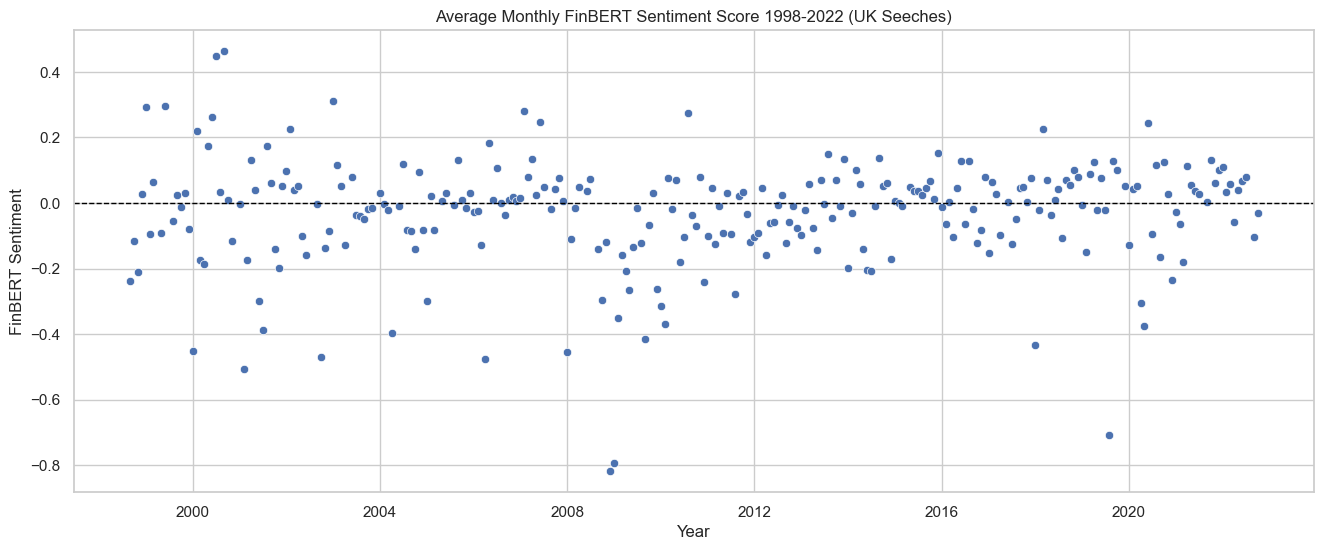

In [137]:
# Plot
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.scatterplot(data=avg_bert, x='year_month', y='finbert_score', marker ='o')

# Define date format
date_format = mdates.DateFormatter('%Y')

# Set the x-axis
ax.xaxis.set_major_formatter(date_format)

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Set labels
plt.xlabel('Year')
plt.ylabel('FinBERT Sentiment')

# Set title
plt.title('Average Monthly FinBERT Sentiment Score 1998-2022 (UK Seeches)')

# Display the plot
plt.show()

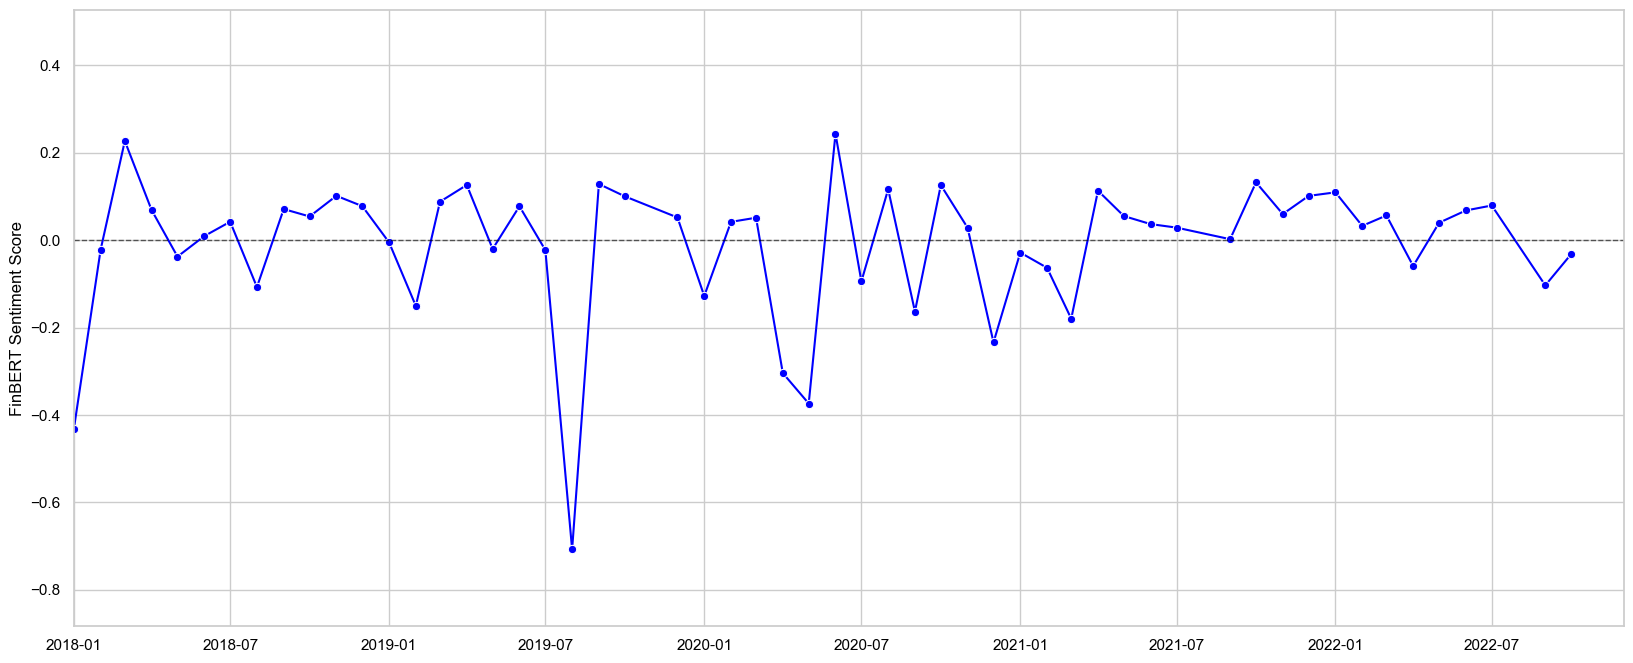

In [138]:
# Plot
# Create the plot size.
plt.figure(figsize=(20, 8))

# Line plot
ax = sns.lineplot(data=avg_bert, x='year_month', y='finbert_score', marker ='o', color='blue')

# Set labels
plt.xlabel('')
plt.ylabel('FinBERT Sentiment Score', color='black')

# Set x-axis limits
ax.set_xlim([pd.to_datetime('2018-01-01'), pd.to_datetime('2022-12-01')])

# Set title
plt.title('')

plt.xticks(color='black')
plt.yticks(color='black')

plt.axhline(y=0, color='black', alpha=0.6, linestyle='--', linewidth=1)

plt.savefig('Avg_FinBert_2018-2022.png')

# Display the plot
plt.show()

**Observation**:

2019-02. Mark Carney 'The Global Outlook' Speech.
- Available at: https://www.bankofengland.co.uk/speech/2019/mark-carney-speech

2019-08. Mark Carney: The Growing Challenges for Monetary Policy in the current
International Monetary and Financial System - Available at: https://www.bankofengland.co.uk/-/media/boe/files/speech/2019/the-growing-challenges-for-monetary-policy-speech-by-mark-carney.pdf 

2020-43 and 2020-54. BoE Speech on Monetary Policy and Covid-19's Economic Impact. 
- Available at: https://www.bankofengland.co.uk/speech/2020/gertjan-vlieghe-speech-monetary-policy-and-the-boes-balance-sheet
- Available at: https://www.bankofengland.co.uk/speech/2020/speech-by-michael-saunders-28-may-2020

2020-05. BoE Speeches on the resilience of the financial system following the onset Covid-19. Highlightes the benefits of post GFC reforms, such as higher liquidity and capital requirements, central bank intervention, and international cooperation led by the Financial Stability Board (FSB)
-  Available at: https://www.bankofengland.co.uk/speech/2020/jon-cunliffe-speech-at-investment-association
-  Available at: https://www.bankofengland.co.uk/speech/2020/andrew-hauser-speech-hosted-by-bloomberg-via-webinar

2022: Russian invasion of Ukraine in Feb, and then Truss mini-budget in September that required BoE intervention
- Available at: https://www.bankofengland.co.uk/speech/2022/october/andrew-bailey-opening-remarks-and-panellist-37th-annual-international-banking-seminar

In [139]:
bert_sentiment_uk['date'].max()

Timestamp('2022-10-20 00:00:00')

In [140]:
bert_sentiment_uk[bert_sentiment_uk['year_month'] == '2016-07']

,reference,country,date,quarter,year_month,weekday,year,title,author,is_gov,len,text,speech_tokens,filtered_tokens,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,finbert_score,team_sentiment
806,r160715a_BOE,united kingdom,2016-07-15,2016Q3,2016-07-01,Friday,2016,Whose Recovery?,haldane,0,49529,it is a great pleasure to be here in port talb...,"['it', 'is', 'a', 'great', 'pleasure', 'to', '...","['great', 'pleasure', 'port', 'talbot', 'want'...",0.042590,0.104524,0.852886,neutral,-0.061933,neutral
807,r160718a_BOE,united kingdom,2016-07-18,2016Q3,2016-07-01,Monday,2016,Brexit and Monetary Policy,weale,0,43271,thank you for inviting me here for my last out...,"['thank', 'you', 'for', 'inviting', 'me', 'her...","['thank', 'inviting', 'last', 'outside', 'appe...",0.048177,0.112265,0.839558,neutral,-0.064089,neutral


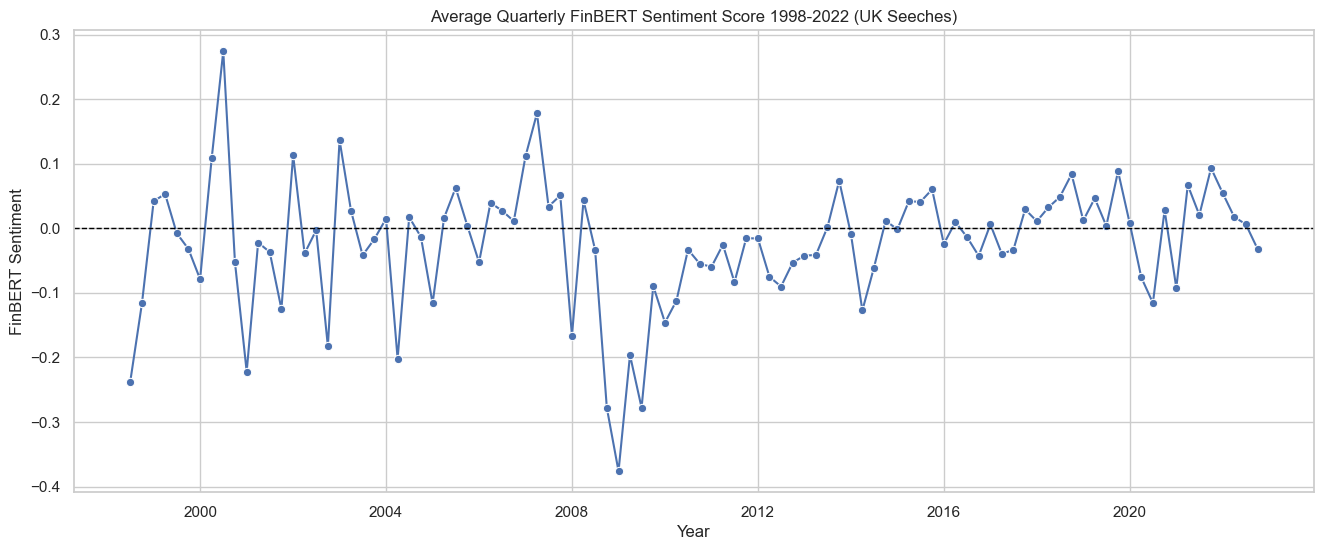

In [141]:
# Plot
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.lineplot(data=quart_bert, x='quarter', y='finbert_score', marker ='o')

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Set labels
plt.xlabel('Year')
plt.ylabel('FinBERT Sentiment')

# Set title
plt.title('Average Quarterly FinBERT Sentiment Score 1998-2022 (UK Seeches)')

# Display the plot
plt.show()

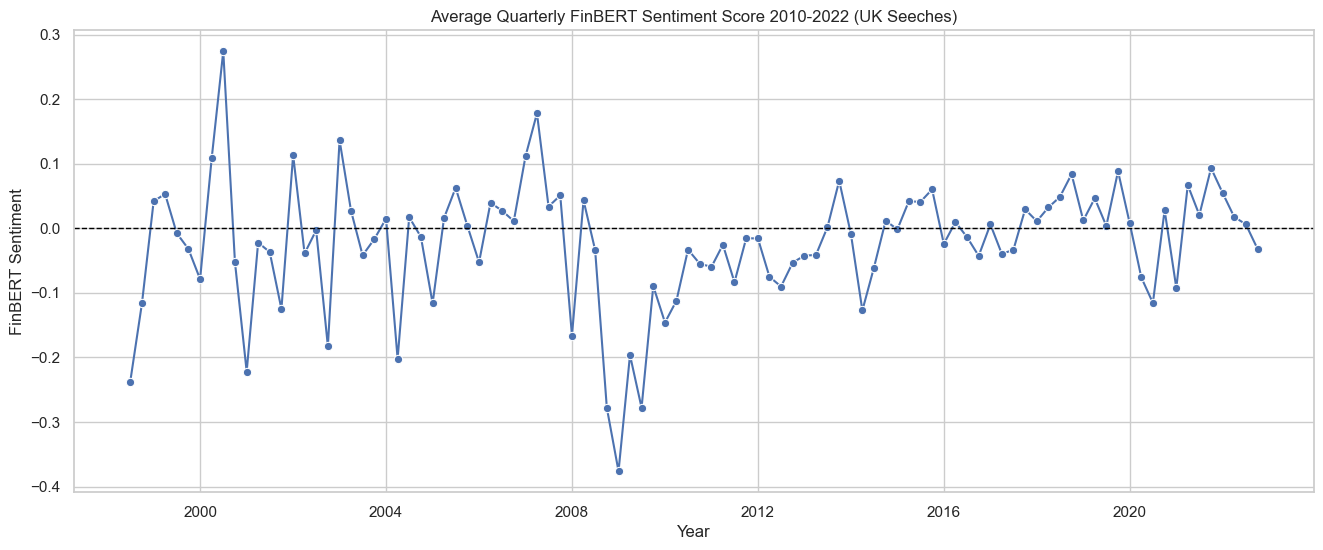

In [142]:
# Plot
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.lineplot(data=quart_bert, x='quarter', y='finbert_score', marker ='o')

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Set labels
plt.xlabel('Year')
plt.ylabel('FinBERT Sentiment')

# Set title
plt.title('Average Quarterly FinBERT Sentiment Score 2010-2022 (UK Seeches)')

# Display the plot
plt.show()

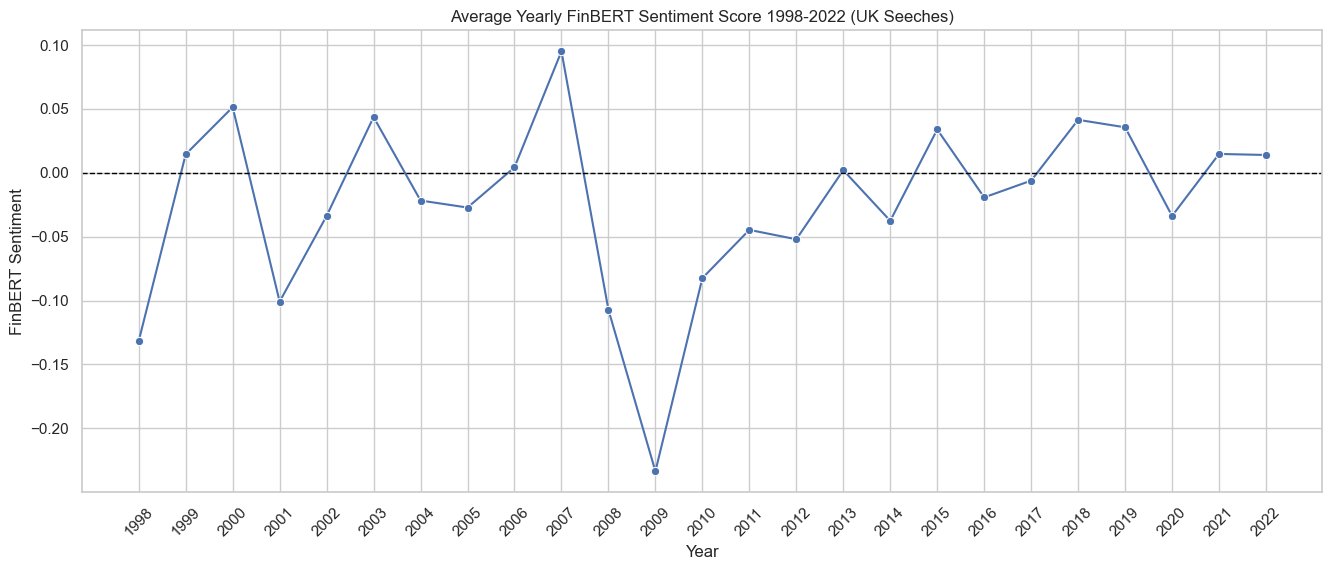

In [143]:
# Plot
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.lineplot(data=bert_sentiment_uk.groupby('year')['finbert_score'].mean().reset_index(), x='year', y='finbert_score', marker ='o')

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Set the x-ticks
years = bert_sentiment_uk['year'].unique()
plt.xticks(ticks=years, rotation=45)

# Set labels
plt.xlabel('Year')
plt.ylabel('FinBERT Sentiment')

# Set title
plt.title('Average Yearly FinBERT Sentiment Score 1998-2022 (UK Seeches)')

# Display the plot
plt.show()

**Observation:** Notable fluctuations in average yearly FinBERT sentiment score:
- 2000 to 2001
- 2007, and then the drop in 2008 and 2009 (Global Financial Crisis)
- 2016 and 2017 (Brexit Referendum & Written Notice)
- 2019 and 2020 (Covid-19 and Brexit)

#### FinBERT Model - Aggregate Plots (BoE Governor Speeches)

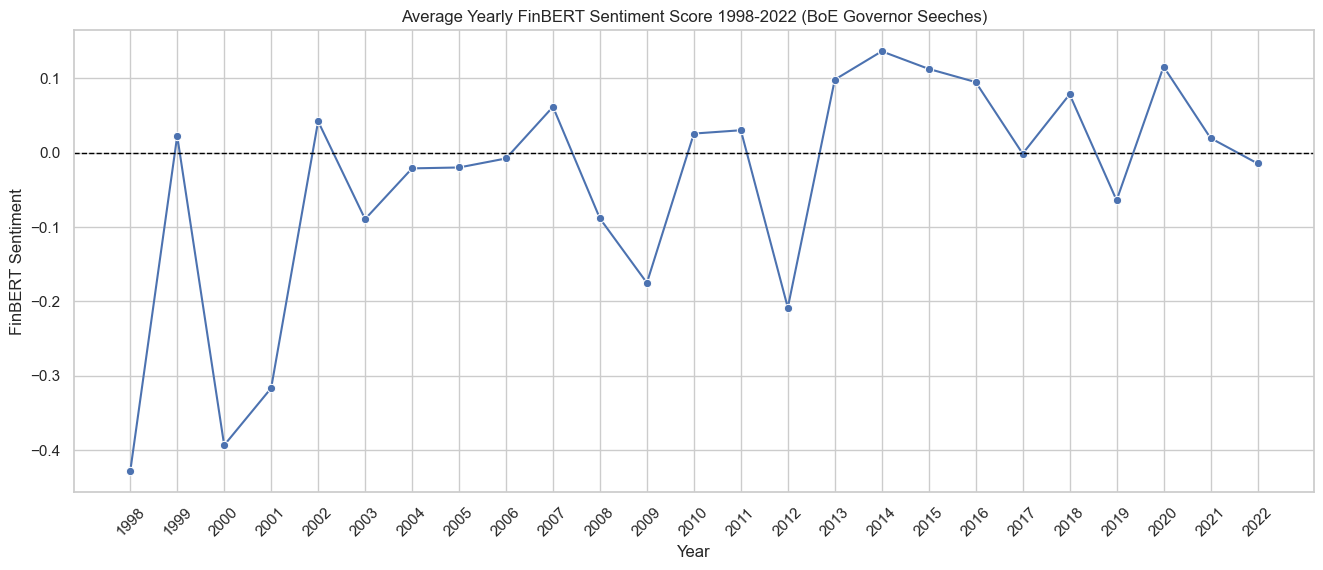

In [144]:
# Plot
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.lineplot(data=bert_sentiment_uk[bert_sentiment_uk['is_gov'] == 1].groupby('year')['finbert_score'].mean().reset_index(), \
                  x='year', y='finbert_score', marker ='o')

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Set the x-ticks
years = bert_sentiment_uk['year'].unique()
plt.xticks(ticks=years, rotation=45)

# Set labels
plt.xlabel('Year')
plt.ylabel('FinBERT Sentiment')

# Set title
plt.title('Average Yearly FinBERT Sentiment Score 1998-2022 (BoE Governor Seeches)')

# Display the plot
plt.show()

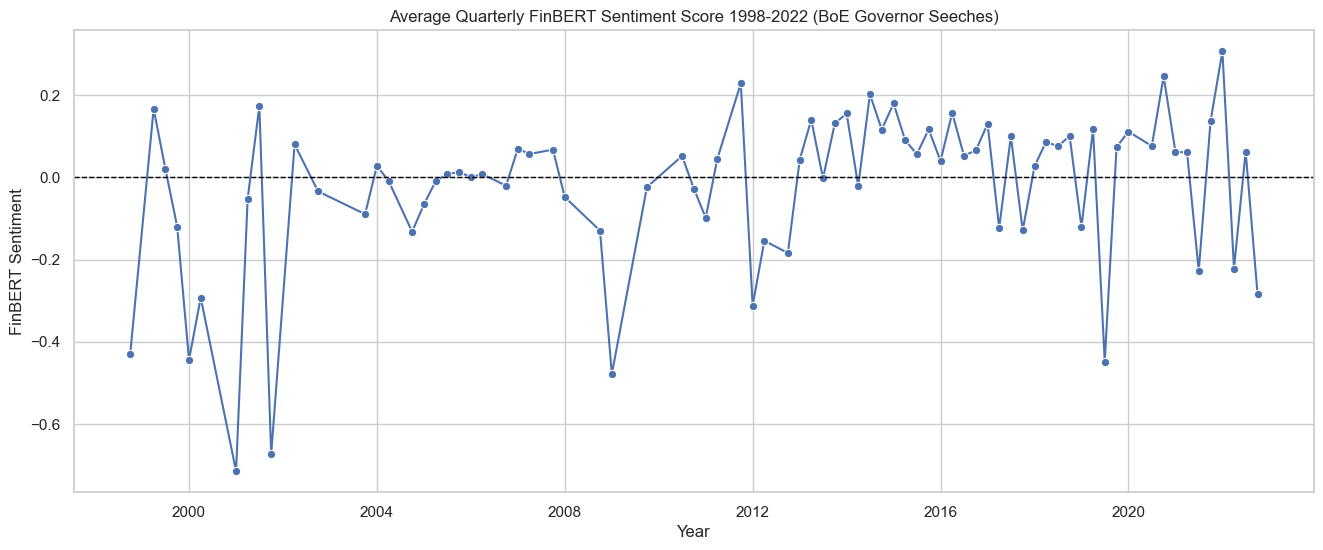

In [145]:
# Plot
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.lineplot(data=quart_bert_gov, x='quarter', y='finbert_score', marker ='o')

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Set labels
plt.xlabel('Year')
plt.ylabel('FinBERT Sentiment')

# Set title
plt.title('Average Quarterly FinBERT Sentiment Score 1998-2022 (BoE Governor Seeches)')

# Display the plot
plt.show()

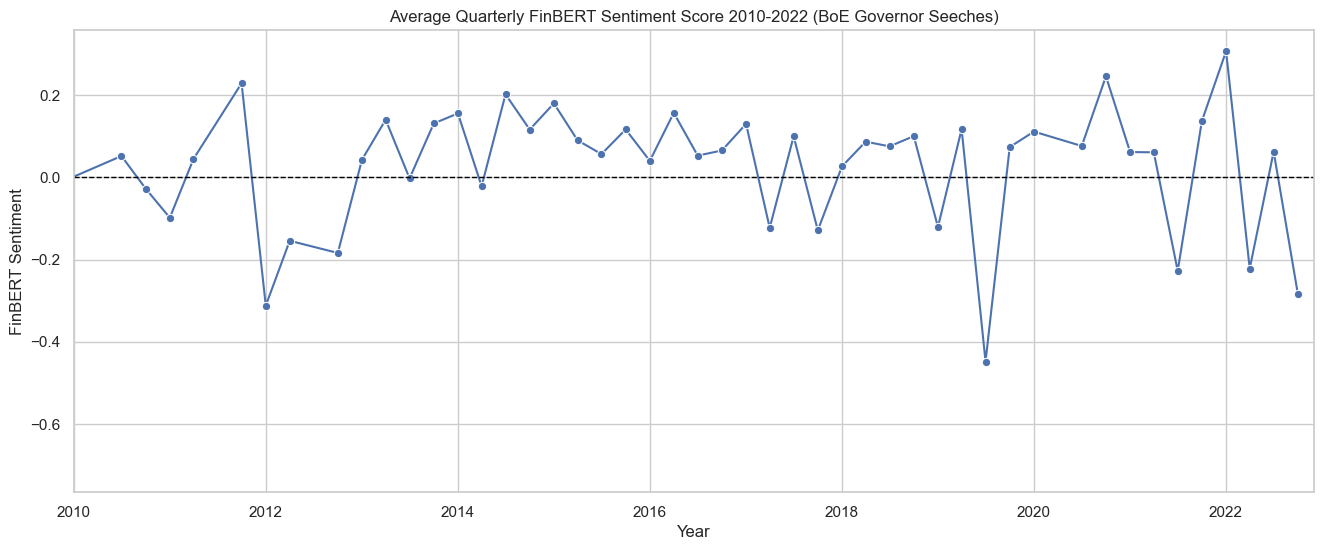

In [146]:
# Plot
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.lineplot(data=quart_bert_gov, x='quarter', y='finbert_score', marker ='o')

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Set labels
plt.xlabel('Year')
plt.ylabel('FinBERT Sentiment')

# Set x-axis limits
ax.set_xlim([pd.to_datetime('2010-01-01'), pd.to_datetime('2022-12-01')])

# Set title
plt.title('Average Quarterly FinBERT Sentiment Score 2010-2022 (BoE Governor Seeches)')

# Display the plot
plt.show()

#### FinBERT Model - Simple Moving Average Plot

<Figure size 2000x600 with 0 Axes>

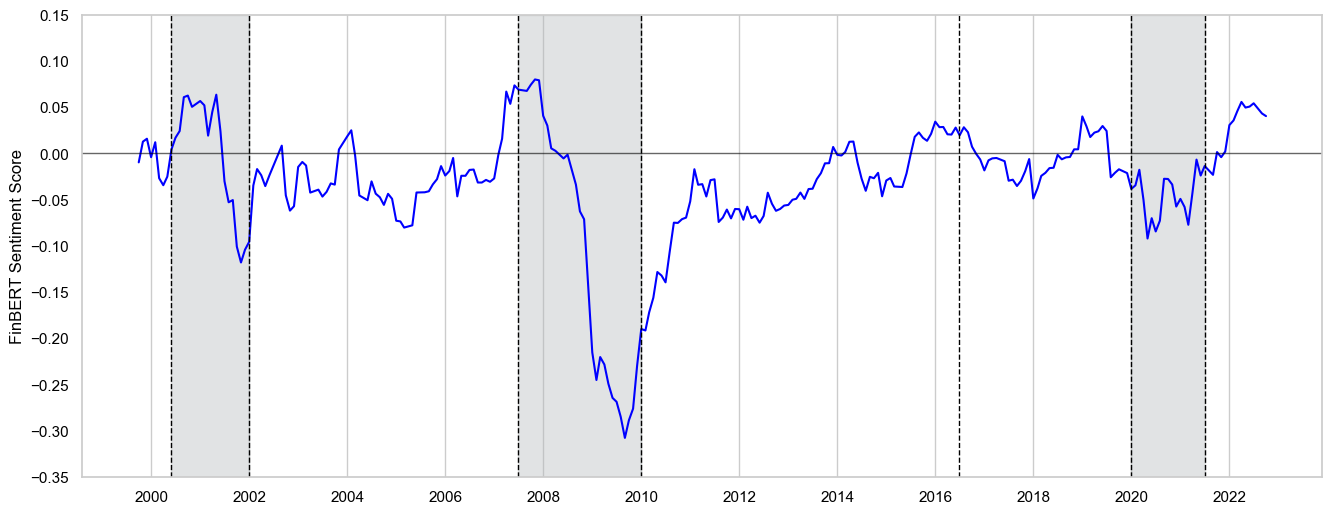

In [147]:
# 12 Month
plt.figure(figsize=(20, 6))
ax = plot_moving_average(avg_bert, 12)

plt.title("", color="black")
plt.ylabel('FinBERT Sentiment Score')
plt.yticks(np.arange(-0.35, 0.2, 0.05))

plt.axvspan(
    pd.to_datetime('2007-07-01'), pd.to_datetime('2010-01-01'),
    color='#B4B9BC', alpha=0.4
)

plt.axvspan(
    pd.to_datetime('2000-06-01'), pd.to_datetime('2002-01-01'),
    color='#B4B9BC', alpha=0.4
)

plt.axvline(pd.to_datetime('2016-06-23'), linestyle='--', color='black', linewidth=1)
plt.axvline(pd.to_datetime('2007-07-01'), linestyle='--', color='black', linewidth=1)
plt.axvline(pd.to_datetime('2010-01-01'), linestyle='--', color='black', linewidth=1)
plt.axvline(pd.to_datetime('2002-01-01'), linestyle='--', color='black', linewidth=1)
plt.axvline(pd.to_datetime('2000-06-01'), linestyle='--', color='black', linewidth=1)
plt.axvline(pd.to_datetime('2020-01-01'), linestyle='--', color='black', linewidth=1)
plt.axvline(pd.to_datetime('2021-07-01'), linestyle='--', color='black', linewidth=1)

plt.axvspan(
    pd.to_datetime('2020-01-01'), pd.to_datetime('2021-07-01'),
    color='#B4B9BC', alpha=0.4
)

plt.grid(axis='y', color='none')
plt.axhline(y=0, color='black', alpha=0.6, linestyle='-', linewidth=1)
        
plt.savefig('12-Month_SMA.png') 

<Figure size 2000x600 with 0 Axes>

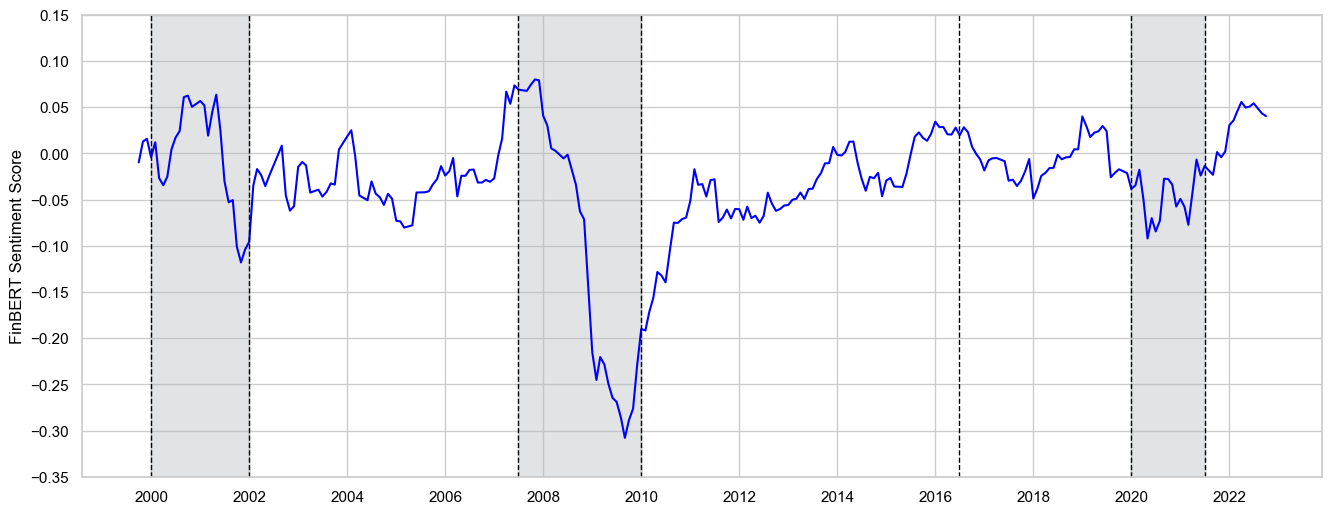

In [148]:
# 12 Month
plt.figure(figsize=(20, 6))
ax = plot_moving_average(avg_bert, 12)

plt.title("", color="black")
plt.ylabel('FinBERT Sentiment Score')
plt.yticks(np.arange(-0.35, 0.2, 0.05))

plt.axvspan(
    pd.to_datetime('2007-07-01'), pd.to_datetime('2010-01-01'),
    color='#B4B9BC', alpha=0.4
)

plt.axvspan(
    pd.to_datetime('2000-01-01'), pd.to_datetime('2002-01-01'),
    color='#B4B9BC', alpha=0.4
)

plt.axvline(pd.to_datetime('2016-06-23'), linestyle='--', color='black', linewidth=1)
plt.axvline(pd.to_datetime('2007-07-01'), linestyle='--', color='black', linewidth=1)
plt.axvline(pd.to_datetime('2010-01-01'), linestyle='--', color='black', linewidth=1)
plt.axvline(pd.to_datetime('2002-01-01'), linestyle='--', color='black', linewidth=1)
plt.axvline(pd.to_datetime('2000-01-01'), linestyle='--', color='black', linewidth=1)
plt.axvline(pd.to_datetime('2020-01-01'), linestyle='--', color='black', linewidth=1)
plt.axvline(pd.to_datetime('2021-07-01'), linestyle='--', color='black', linewidth=1)

plt.axvspan(
    pd.to_datetime('2020-01-01'), pd.to_datetime('2021-07-01'),
    color='#B4B9BC', alpha=0.4
)
        
plt.savefig('12-Month_SMA_2.png')

**Observation:** 6 Month SMA below

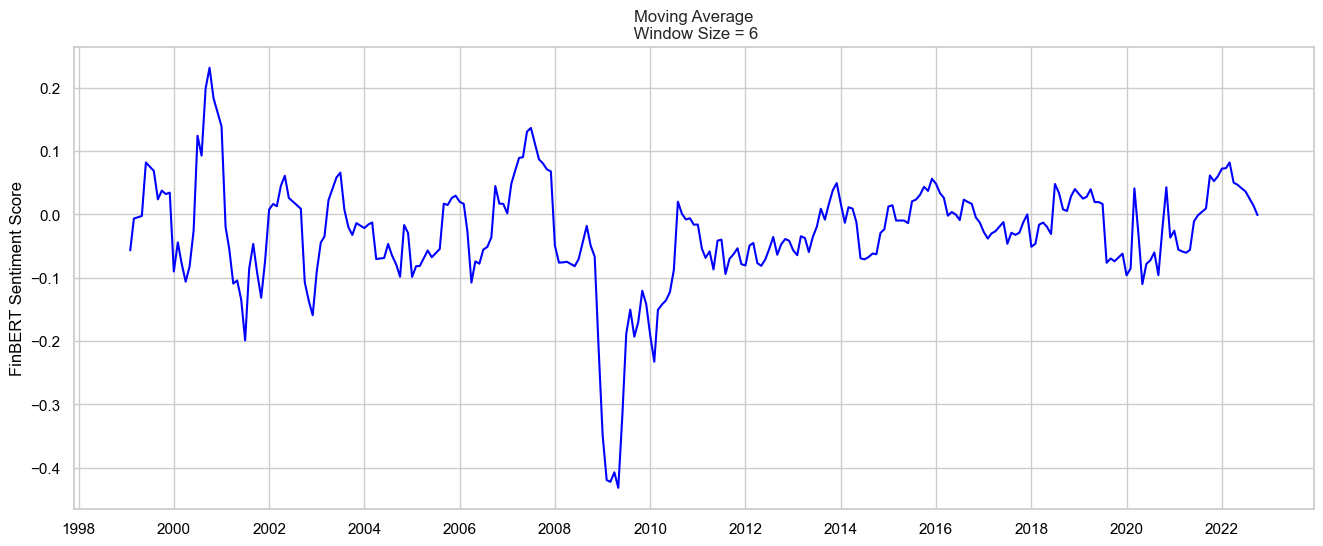

In [149]:
# 6 Month
plot_moving_average(avg_bert, 6)

In [150]:
# Create monthly average DataFrame for Governor Speeches
avg_bert_gov = pd.DataFrame(bert_sentiment_uk[bert_sentiment_uk['is_gov'] == 1].groupby('year_month')['finbert_score'].mean())

**Observation:** 6 Month SMA below of only BoE Governor speeches

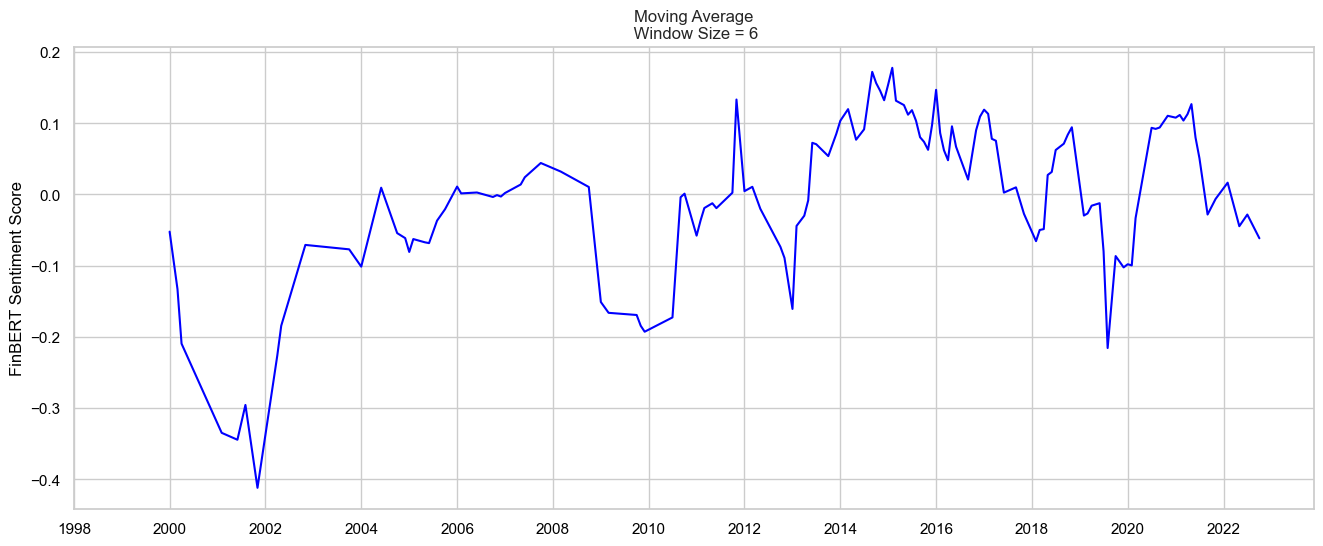

In [151]:
# 6 Month
plot_moving_average(avg_bert_gov, 6)

#### FinBERT Model - Isolating Positive / Negative Speeches

In [152]:
# Only positive / negative speeches
pos_neg_bert_uk = bert_sentiment_uk[bert_sentiment_uk['finbert_sentiment'] != 'neutral']

# View
pos_neg_bert_uk.head(2)

,reference,country,date,quarter,year_month,weekday,year,title,author,is_gov,len,text,speech_tokens,filtered_tokens,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,finbert_score,team_sentiment
2,r981021a_BOE,united kingdom,1998-10-21,1998Q4,1998-10-01,Wednesday,1998,Impact of the recent turbulence in internation...,king,1,13678,few industries have suffered more from volatil...,"['few', 'industries', 'have', 'suffered', 'mor...","['industries', 'suffered', 'volatility', 'brit...",0.047679,0.476351,0.475970,negative,-0.428672,negative
5,r981119a_BOE,united kingdom,1998-11-19,1998Q4,1998-11-01,Thursday,1998,Speech,george,0,13298,let me put some of the recent newspaper headli...,"['let', 'me', 'put', 'some', 'of', 'the', 'rec...","['let', 'put', 'recent', 'newspaper', 'headlin...",0.070057,0.687193,0.242751,negative,-0.617136,negative


In [153]:
# Shape
pos_neg_bert_uk.shape

(151, 20)

In [154]:
# Percent of BoE Governor speeches in positive / negative dataset
round(pos_neg_bert_uk['is_gov'].agg('sum') / pos_neg_bert_uk.shape[0], 2)

0.11

In [155]:
# Percent of BoE Governor speeches in overall UK dataset
round(bert_sentiment_uk['is_gov'].agg('sum') / bert_sentiment_uk.shape[0], 2)

0.16

In [156]:
# Percent of BoE Governor speeches in neutral dataset
round(bert_sentiment_uk[bert_sentiment_uk['finbert_sentiment'] == 'neutral']\
            ['is_gov'].agg('sum') / bert_sentiment_uk[bert_sentiment_uk['finbert_sentiment'] == 'neutral'].shape[0], 2)

0.16

In [157]:
# Sentiment distribution (BoE Governor speeches)
bert_govcounts = bert_sentiment_uk[bert_sentiment_uk['is_gov']== 1]['team_sentiment'].value_counts()

# Calculate the percentage distribution
print((bert_govcounts / bert_govcounts.sum()) * 100)

team_sentiment
neutral             57.894737
neutral-positive    26.842105
negative             6.842105
neutral-negative     6.315789
positive             2.105263
Name: count, dtype: float64


In [158]:
# Sentiment distribution (NOT BoE Governor speeches)
bert_ngovcounts = bert_sentiment_uk[bert_sentiment_uk['is_gov']== 0]['team_sentiment'].value_counts()

# Calculate the percentage distribution
print((bert_ngovcounts / bert_ngovcounts.sum()) * 100)

team_sentiment
neutral             59.470069
neutral-positive    17.762512
neutral-negative     9.617272
negative             9.617272
positive             3.532875
Name: count, dtype: float64


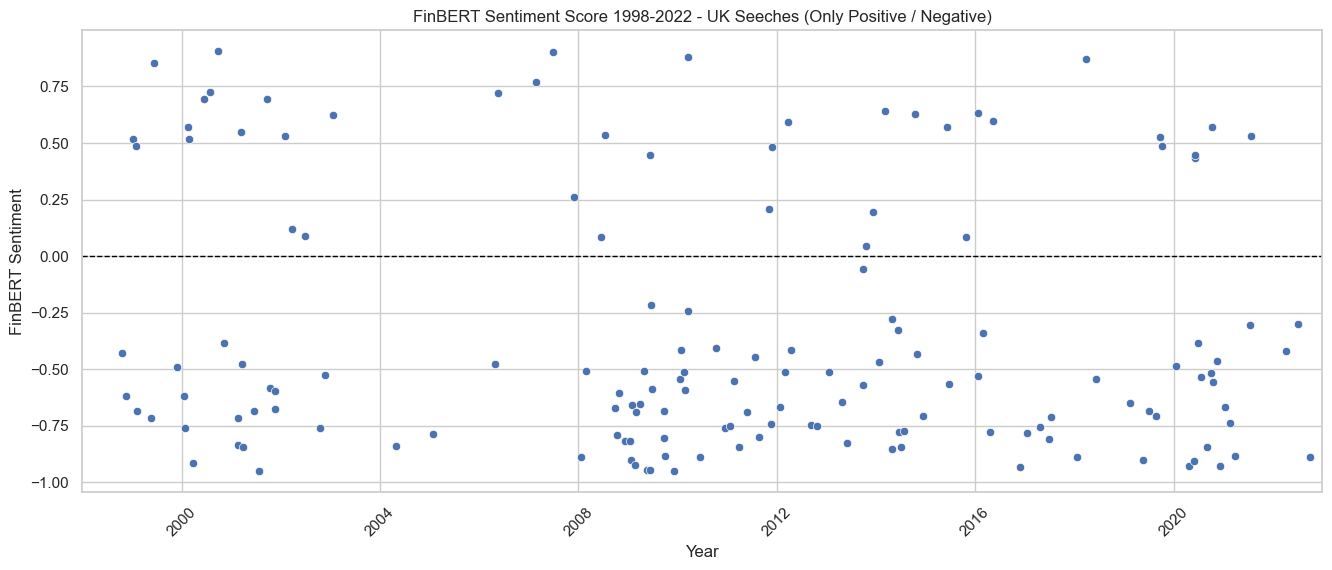

In [159]:
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.scatterplot(data=pos_neg_bert_uk, x='date', y='finbert_score', marker ='o')

# Define date format
date_format = mdates.DateFormatter('%Y')

# Set the x-axis
ax.xaxis.set_major_formatter(date_format)

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# X-Axis Limit
ax.set_xlim([pd.Timestamp('1998-01-01'), pd.Timestamp('2022-12-31')])

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Set labels
plt.xlabel('Year')
plt.ylabel('FinBERT Sentiment')

# Set title
plt.title('FinBERT Sentiment Score 1998-2022 - UK Seeches (Only Positive / Negative)')

# Display the plot
plt.show()

In [160]:
# Group by 'year' and 'sentiment' and count the number of speeches
sentiment_counts_bert = pos_neg_bert_uk.groupby(['year', 'finbert_sentiment']).size().unstack(fill_value=0)

# Calculate the difference
sentiment_counts_bert['net_difference'] = sentiment_counts_bert['positive'] - sentiment_counts_bert['negative']

# Reset the index to convert the grouped result back to a DataFrame
sentiment_counts_bert = sentiment_counts_bert.reset_index()

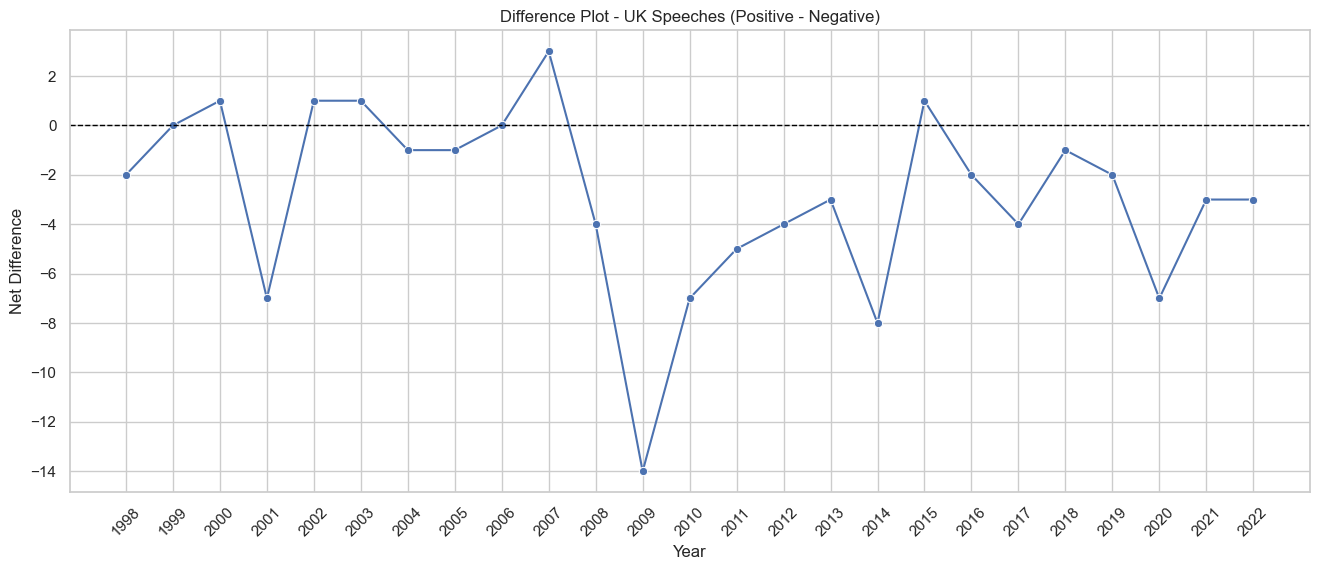

In [161]:
from matplotlib.ticker import MaxNLocator

# Plot
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.lineplot(data=sentiment_counts_bert, x='year', y='net_difference', marker ='o')

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Set the x-ticks
years = bert_sentiment_uk['year'].unique()
plt.xticks(ticks=years, rotation=45)

# Set labels
plt.xlabel('Year')
plt.ylabel('Net Difference')

# Set y-axis ticks to be whole numbers
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Set title
plt.title('Difference Plot - UK Speeches (Positive - Negative)')

# Display the plot
plt.show()

**Observation:** Drop in the yearly net difference between postive and negative speeches in:
- 2001
- 2008 and 2009 (Global Financial Crisis)
- 2014
- 2016 and 2017 (Brexit Referendum & Written Notice)
- 2019 and 2020 (Covid-19 and Brexit)

In [162]:
# Create DataFrame over all that are not totally 'Neutral'
not_neu_uk = bert_sentiment_uk[bert_sentiment_uk['team_sentiment'] != 'neutral']

# View
not_neu_uk.head(2)

,reference,country,date,quarter,year_month,weekday,year,title,author,is_gov,len,text,speech_tokens,filtered_tokens,finbert_pos,finbert_neg,finbert_neu,finbert_sentiment,finbert_score,team_sentiment
0,r980915a_BOE,united kingdom,1998-09-15,1998Q3,1998-09-01,Tuesday,1998,Speech,george,0,13731,thank you chairman im actually very pleased to...,"['thank', 'you', 'chairman', 'im', 'actually',...","['thank', 'chairman', 'im', 'actually', 'pleas...",0.087535,0.325207,0.587258,neutral,-0.237672,neutral-negative
1,r981021b_BOE,united kingdom,1998-10-21,1998Q4,1998-10-01,Wednesday,1998,Britain in Europe,george,0,24263,its a great pleasure to be here in the beautif...,"['its', 'a', 'great', 'pleasure', 'to', 'be', ...","['great', 'pleasure', 'beautiful', 'city', 'br...",0.212209,0.017505,0.770286,neutral,0.194704,neutral-positive


In [163]:
# View
not_neu_uk.shape

(493, 20)

**Observation:** 493 with a 'Positive' / 'Negative' lean

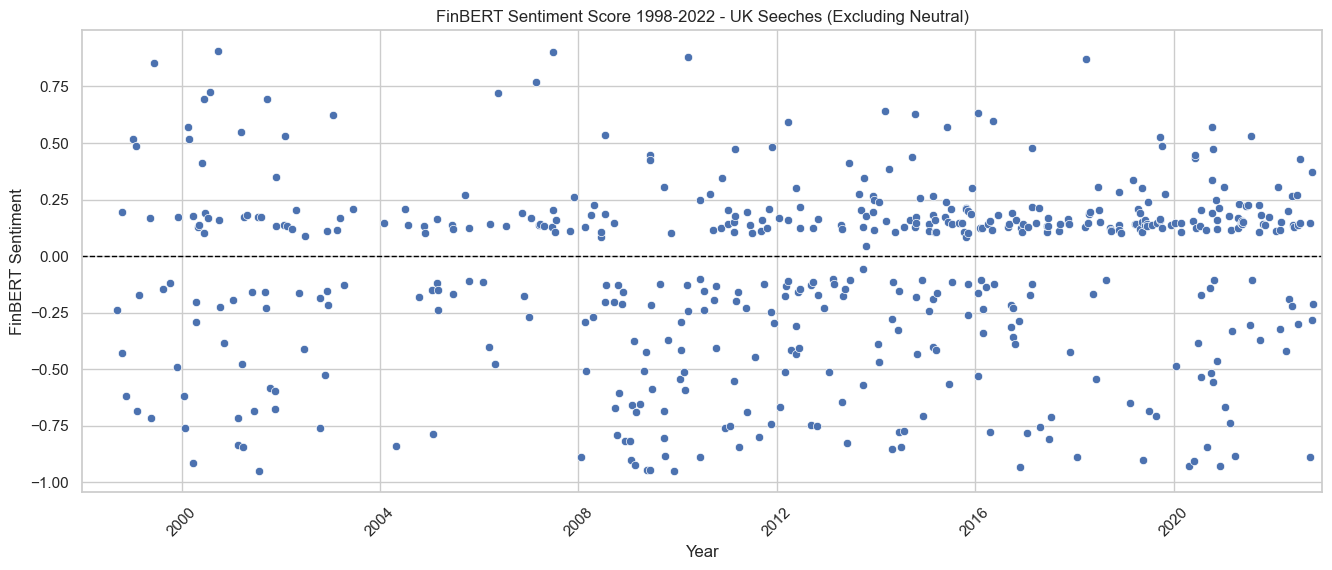

In [164]:
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.scatterplot(data=not_neu_uk, x='date', y='finbert_score', marker ='o')

# Define date format
date_format = mdates.DateFormatter('%Y')

# Set the x-axis
ax.xaxis.set_major_formatter(date_format)

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# X-Axis Limit
ax.set_xlim([pd.Timestamp('1998-01-01'), pd.Timestamp('2022-12-31')])

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Set labels
plt.xlabel('Year')
plt.ylabel('FinBERT Sentiment')

# Set title
plt.title('FinBERT Sentiment Score 1998-2022 - UK Seeches (Excluding Neutral)')

# Display the plot
plt.show()

In [165]:
# Group by 'year' and 'sentiment' and count the number of speeches
sent_cnts_brt = not_neu_uk.groupby(['year', 'team_sentiment']).size().unstack(fill_value=0)

# Calculate the difference
sent_cnts_brt['net_difference'] = (sent_cnts_brt['positive'] + sent_cnts_brt['neutral-positive']) - \
(sent_cnts_brt['negative'] + sent_cnts_brt['neutral-negative'])

# Reset the index to convert the grouped result back to a DataFrame
sent_cnts_brt = sent_cnts_brt.reset_index()

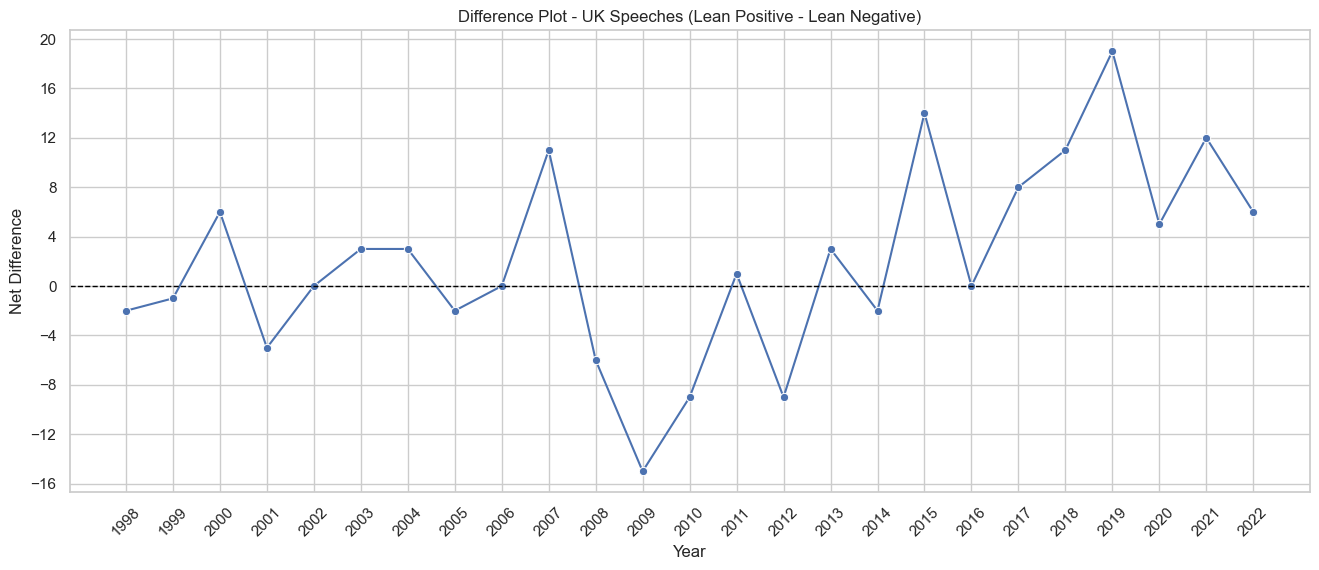

In [166]:
from matplotlib.ticker import MaxNLocator

# Plot
# Create the plot size.
plt.figure(figsize=(16, 6))

# Line plot
ax = sns.lineplot(data=sent_cnts_brt, x='year', y='net_difference', marker ='o')

# Adding a horizontal dashed line at y=0
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Set the x-ticks
years = bert_sentiment_uk['year'].unique()
plt.xticks(ticks=years, rotation=45)

# Set labels
plt.xlabel('Year')
plt.ylabel('Net Difference')

# Set y-axis ticks to be whole numbers
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Set title
plt.title('Difference Plot - UK Speeches (Lean Positive - Lean Negative)')

# Display the plot
plt.show()

### Important CSV Files

In [167]:
# VADER & TextBlob
uk_speech_sentiment.to_csv('uk_speech_sentiment.csv', index=False)

In [168]:
# FinBERT
bert_sentiment_uk.to_csv('bert_sentiment_uk.csv', index=False)

In [169]:
# LM Dictionary
lm_sentiment_uk.to_csv('lm_sentiment_uk.csv', index=False)

In [170]:
# Shape
print(uk_speech_sentiment.shape)
print(bert_sentiment_uk.shape)
print(lm_sentiment_uk.shape)

(1209, 19)
(1209, 20)
(1209, 21)
